# Preliminary analysis of extracted convolutional layers

### includes auto MP fits and mp soft ranks



In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn

import numpy as np
import powerlaw

import sklearn
from sklearn.decomposition import TruncatedSVD

from tqdm import tqdm_notebook as tqdm

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
import import_ipynb
import RMT_Util

importing Jupyter notebook from RMT_Util.ipynb


/Users/charleshmartin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.14.3
scipy version 1.1.0
tensforflow version 1.10.1
keras version 2.2.2
sklearn version 0.19.1
powerlaw version 1.4.3


Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,5]

### All Linear Models

In [4]:
def list_models(model, plot=True, linear=True, conv2d=False):
    pretrained_model = model(pretrained=True)
    
    model_name = model.__name__
    model_name = model_name.replace("_",' ')
    alphas = []
    soft_ranks = []
    
    for im, m in enumerate(pretrained_model.modules()):
        W = None
        print(im,m)
        if linear and isinstance(m, nn.Linear):     
            W = np.array(m.weight.data.clone().cpu())
        elif conv2d and isinstance(m, nn.Conv2d):
            W = np.array(m.weight.data.clone().cpu())
            # CUT ONE ONE FILTER
            print(W.shape)
            W = RMT_Util.reshape_tensor(W)  
             
        

In [5]:
def get_conv2D_Wmats(Wtensor):
    """Extract W slices from a 4 index conv2D tensor of shape: (N,M,i,j) or (M,N,i,j).  Return ij (N x M) matrices"""
    Wmats = []
    s = Wtensor.shape
    N, M, imax, jmax = s[0],s[1],s[2],s[3]
    print("tensor shape", N,M,imax,jmax)
    for i in range(imax):
        for j in range(jmax):
            W = Wtensor[:,:,i,j]
            if N < M:
                W = W.T
            Wmats.append(W)
    return Wmats

In [6]:
def analyze_model(model, linear=False, conv2d=True, plot=True):
    pretrained_model = model(pretrained=True)
    
    model_name = model.__name__
    model_name = model_name.replace("_",' ')
    alphas = []
    soft_ranks = []
    
    for im, m in enumerate(pretrained_model.modules()):
        Wmats = []
        #print(im, isinstance(m, nn.Conv2d))
        if linear and isinstance(m, nn.Linear):     
            W = np.array(m.weight.data.clone().cpu())
            Wmats = [W]
        elif conv2d and isinstance(m, nn.Conv2d):
            #print("conv2d")
            Wtensor = np.array(m.weight.data.clone().cpu())
            Wmats = get_conv2D_Wmats(Wtensor)
            
        #print("num mats ",len(Wmats))
        if Wmats is not None and len(Wmats)>0:
            for W in Wmats:
                #print(W.shape)

                M, N = np.min(W.shape), np.max(W.shape)
                Q=N/M 
                if M > 49:
                    sv, _ = RMT_Util.singular_spectrum(W)
                    evals = sv*sv
                    #scaled_evals = (1/N)*evals
                    # RMT_Util.fit_power_law
                    fit = powerlaw.Fit(evals, xmax=np.max(evals), verbose=False)  
                    alpha = fit.alpha
                    D = fit.D

                    dist = RMT_Util.best_dist(fit)
                    sigma = RMT_Util.fit_mp(evals, Q)
                    mp_soft_rank = RMT_Util.calc_mp_soft_rank(evals,Q,sigma)

                    print(alpha)

                    alphas.append(alpha)
                    soft_ranks.append(mp_soft_rank)
    return alphas, soft_ranks


### PoweLaw fit for all FC and CNN layers

In [7]:
all_alphas, all_ranks = [], []
for model in tqdm([models.alexnet, 
              models.densenet121, models.densenet161, models.densenet169, models.densenet201, 
              models.inception_v3,
              models.resnet101, models.resnet152, models.resnet18, models.resnet34, models.resnet50, 
              models.squeezenet1_0, models.squeezenet1_1,
              models.vgg11, models.vgg11_bn,
              models.vgg16, models.vgg16_bn,
              models.vgg19, models.vgg19_bn ]):
    #print(model)
    #analyze_model(model, conv2d=True, plot=False)
    alphas, soft_ranks = analyze_model(model)
    all_alphas.extend(alphas)
    all_ranks.extend(soft_ranks)

tensor shape 64 3 11 11
tensor shape 192 64 5 5


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Assuming nested distributions
RMT_Util.ipynb:6: RuntimeWarning: divide by zero encountered in true_divide
  "source": [
RMT_Util.ipynb:6: RuntimeWarning: invalid value encountered in sqrt
  "source": [
Assuming nested distributions


2.2694036569832017
4.722961649791938


Assuming nested distributions


1.6171944212970237


Assuming nested distributions
Assuming nested distributions


3.3876016651016543
1.979106233279397


Assuming nested distributions
Assuming nested distributions


2.8561518994353987
2.4860681695918876


Assuming nested distributions


2.798683715487055
2.3367811665805958


Assuming nested distributions
Assuming nested distributions


2.654377560776404


Assuming nested distributions
Assuming nested distributions


1.8108992803035737
2.4998211536823725


Assuming nested distributions
Assuming nested distributions


3.0541057867627837
2.3122267812708586


Assuming nested distributions


2.120629817770741


Assuming nested distributions


3.240714656810751


Assuming nested distributions
Assuming nested distributions


1.8421637075332866
1.6825083041216626
2.0473960055576406


Assuming nested distributions
Assuming nested distributions


2.153072892784021


Assuming nested distributions
Assuming nested distributions


1.9947378482646343
1.6628092879951046
1.6421963563092974


Assuming nested distributions
Assuming nested distributions


2.3993273553149472


Assuming nested distributions


2.0650326283185843
tensor shape 384 192 3 3


Assuming nested distributions


3.1259507274568143


Assuming nested distributions


2.0702629475359147


Assuming nested distributions


2.762697552127029


Assuming nested distributions


3.435511925239208


Assuming nested distributions


1.716616655658593


Assuming nested distributions


3.2634879474155056


Assuming nested distributions


3.15078014190948


Assuming nested distributions


4.279632265944562


Assuming nested distributions


3.126485260972242
tensor shape 256 384 3 3


Assuming nested distributions


3.17197002773621


Assuming nested distributions


3.0716217082223216


Assuming nested distributions
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:1605: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.549030237666459


Assuming nested distributions


2.5907386324545714


Assuming nested distributions


2.1180937422599566


Assuming nested distributions


2.501139201270889


Assuming nested distributions


3.477434356663204


Assuming nested distributions


2.578929346983003


Assuming nested distributions


3.4604371253473567
tensor shape 256 256 3 3


Assuming nested distributions
RMT_Util.ipynb:6: RuntimeWarning: invalid value encountered in multiply
  "source": [


3.5359550388151475


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.6536854985063583


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.28157093730877


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.734469422299474


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.023979127334446


Assuming nested distributions


3.2473863390619147


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.1984864464847345


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.5622847472139867


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.160190029008206
tensor shape 64 3 7 7
tensor shape 128 64 1 1


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Assuming nested distributions


1.3668461110100887
tensor shape 32 128 3 3
tensor shape 128 96 1 1


Assuming nested distributions


1.4743414192605047
tensor shape 32 128 3 3
tensor shape 128 128 1 1


Assuming nested distributions


2.652970303289896
tensor shape 32 128 3 3
tensor shape 128 160 1 1


Assuming nested distributions


3.6814288045454453
tensor shape 32 128 3 3
tensor shape 128 192 1 1


Assuming nested distributions


4.541344221777104
tensor shape 32 128 3 3
tensor shape 128 224 1 1


Assuming nested distributions


6.899431711140578
tensor shape 32 128 3 3
tensor shape 128 256 1 1


Assuming nested distributions


4.728788916257271
tensor shape 128 128 1 1


Assuming nested distributions


1.4750179210418686
tensor shape 32 128 3 3
tensor shape 128 160 1 1


Assuming nested distributions


1.4783860330797183
tensor shape 32 128 3 3
tensor shape 128 192 1 1


Assuming nested distributions


1.520646528600607
tensor shape 32 128 3 3
tensor shape 128 224 1 1


Assuming nested distributions


1.8894355296767888
tensor shape 32 128 3 3
tensor shape 128 256 1 1


Assuming nested distributions


1.80875693100019
tensor shape 32 128 3 3
tensor shape 128 288 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.021120478757148
tensor shape 32 128 3 3
tensor shape 128 320 1 1


Assuming nested distributions


2.2421175306316963
tensor shape 32 128 3 3
tensor shape 128 352 1 1


Assuming nested distributions


3.0542279533574153
tensor shape 32 128 3 3
tensor shape 128 384 1 1


Assuming nested distributions


4.020763892660823
tensor shape 32 128 3 3
tensor shape 128 416 1 1


Assuming nested distributions


2.4293801272396274
tensor shape 32 128 3 3
tensor shape 128 448 1 1


Assuming nested distributions


3.551436033447557
tensor shape 32 128 3 3
tensor shape 128 480 1 1


Assuming nested distributions


6.550401380399791
tensor shape 32 128 3 3
tensor shape 256 512 1 1


Assuming nested distributions


5.347565057188104
tensor shape 128 256 1 1


Assuming nested distributions


1.932688795571953
tensor shape 32 128 3 3
tensor shape 128 288 1 1


Assuming nested distributions


4.340110452322067
tensor shape 32 128 3 3
tensor shape 128 320 1 1


Assuming nested distributions


3.409719725398383
tensor shape 32 128 3 3
tensor shape 128 352 1 1


Assuming nested distributions


5.18376421527394
tensor shape 32 128 3 3
tensor shape 128 384 1 1


Assuming nested distributions


7.023860380346254
tensor shape 32 128 3 3
tensor shape 128 416 1 1


Assuming nested distributions


3.335676469220947
tensor shape 32 128 3 3
tensor shape 128 448 1 1


Assuming nested distributions


1.8350035943509382
tensor shape 32 128 3 3
tensor shape 128 480 1 1


Assuming nested distributions


3.558888886194075
tensor shape 32 128 3 3
tensor shape 128 512 1 1


Assuming nested distributions


3.6853661298102973
tensor shape 32 128 3 3
tensor shape 128 544 1 1


Assuming nested distributions


2.2114398442436447
tensor shape 32 128 3 3
tensor shape 128 576 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.228176205583519
tensor shape 32 128 3 3
tensor shape 128 608 1 1


Assuming nested distributions


3.042525986273784
tensor shape 32 128 3 3
tensor shape 128 640 1 1


Assuming nested distributions


2.2301200559182632
tensor shape 32 128 3 3
tensor shape 128 672 1 1


Assuming nested distributions


3.1456937203911055
tensor shape 32 128 3 3
tensor shape 128 704 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


8.112051030303535
tensor shape 32 128 3 3
tensor shape 128 736 1 1


Assuming nested distributions


5.027630296184582
tensor shape 32 128 3 3
tensor shape 128 768 1 1


Assuming nested distributions


2.765789207323407
tensor shape 32 128 3 3
tensor shape 128 800 1 1


Assuming nested distributions


3.729425964375049
tensor shape 32 128 3 3
tensor shape 128 832 1 1


Assuming nested distributions


2.6266978160638215
tensor shape 32 128 3 3
tensor shape 128 864 1 1


Assuming nested distributions


4.716727296940687
tensor shape 32 128 3 3
tensor shape 128 896 1 1


Assuming nested distributions


3.6265865942182245
tensor shape 32 128 3 3
tensor shape 128 928 1 1


Assuming nested distributions


2.877968001690566
tensor shape 32 128 3 3
tensor shape 128 960 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.0179756321564595
tensor shape 32 128 3 3
tensor shape 128 992 1 1


Assuming nested distributions


5.361481011080407
tensor shape 32 128 3 3
tensor shape 512 1024 1 1


Assuming nested distributions


5.364735609880032
tensor shape 128 512 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.618703948618477
tensor shape 32 128 3 3
tensor shape 128 544 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.194112619596163
tensor shape 32 128 3 3
tensor shape 128 576 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.966950203168626
tensor shape 32 128 3 3
tensor shape 128 608 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.782556887533473
tensor shape 32 128 3 3
tensor shape 128 640 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.072738925118767
tensor shape 32 128 3 3
tensor shape 128 672 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.925068438289125
tensor shape 32 128 3 3
tensor shape 128 704 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.442722650444022
tensor shape 32 128 3 3
tensor shape 128 736 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.056358098797121
tensor shape 32 128 3 3
tensor shape 128 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.497451820366009
tensor shape 32 128 3 3
tensor shape 128 800 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.041503609987689
tensor shape 32 128 3 3
tensor shape 128 832 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.5995716546883845
tensor shape 32 128 3 3
tensor shape 128 864 1 1


Assuming nested distributions


5.249587925099036
tensor shape 32 128 3 3
tensor shape 128 896 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.796376338756172
tensor shape 32 128 3 3
tensor shape 128 928 1 1


Assuming nested distributions


5.070726561892097
tensor shape 32 128 3 3
tensor shape 128 960 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.225426840214289
tensor shape 32 128 3 3
tensor shape 128 992 1 1


Assuming nested distributions


5.0957601820230725
tensor shape 32 128 3 3
tensor shape 96 3 7 7
tensor shape 192 96 1 1
1.3647283971886055
tensor shape 48 192 3 3
tensor shape 192 144 1 1


Assuming nested distributions
Assuming nested distributions


1.3985979917025153
tensor shape 48 192 3 3
tensor shape 192 192 1 1


Assuming nested distributions


2.6651745476047846
tensor shape 48 192 3 3
tensor shape 192 240 1 1


Assuming nested distributions


4.288264177397375
tensor shape 48 192 3 3
tensor shape 192 288 1 1


Assuming nested distributions


3.0452396659849708
tensor shape 48 192 3 3
tensor shape 192 336 1 1


Assuming nested distributions


5.913553794065263
tensor shape 48 192 3 3
tensor shape 192 384 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.584058600703187
tensor shape 192 192 1 1


Assuming nested distributions
Assuming nested distributions


1.5709560248220633
tensor shape 48 192 3 3
tensor shape 192 240 1 1
1.4826087254275029
tensor shape 48 192 3 3
tensor shape 192 288 1 1


Assuming nested distributions


1.9773232262965843
tensor shape 48 192 3 3
tensor shape 192 336 1 1


Assuming nested distributions


1.5926321021941399
tensor shape 48 192 3 3
tensor shape 192 384 1 1


Assuming nested distributions


1.5619159975096117
tensor shape 48 192 3 3
tensor shape 192 432 1 1


Assuming nested distributions


1.5974835994075622
tensor shape 48 192 3 3
tensor shape 192 480 1 1


Assuming nested distributions


2.426961324734334
tensor shape 48 192 3 3
tensor shape 192 528 1 1


Assuming nested distributions


6.939528000717384
tensor shape 48 192 3 3
tensor shape 192 576 1 1


Assuming nested distributions


1.886398918516082
tensor shape 48 192 3 3
tensor shape 192 624 1 1


Assuming nested distributions


1.9261802314204528
tensor shape 48 192 3 3
tensor shape 192 672 1 1


Assuming nested distributions


2.1724436966451206
tensor shape 48 192 3 3
tensor shape 192 720 1 1


Assuming nested distributions


1.8758851821081814
tensor shape 48 192 3 3
tensor shape 384 768 1 1


Assuming nested distributions


2.8042265674096343
tensor shape 192 384 1 1


Assuming nested distributions


1.9092334321084392
tensor shape 48 192 3 3
tensor shape 192 432 1 1


Assuming nested distributions


3.9591297401014045
tensor shape 48 192 3 3
tensor shape 192 480 1 1


Assuming nested distributions


1.466950398279133
tensor shape 48 192 3 3
tensor shape 192 528 1 1


Assuming nested distributions


1.7644527046885612
tensor shape 48 192 3 3
tensor shape 192 576 1 1


Assuming nested distributions


1.4872275874556578
tensor shape 48 192 3 3
tensor shape 192 624 1 1


Assuming nested distributions


1.8015160968008073
tensor shape 48 192 3 3
tensor shape 192 672 1 1


Assuming nested distributions


4.016293797472266
tensor shape 48 192 3 3
tensor shape 192 720 1 1


Assuming nested distributions


1.5973661177570695
tensor shape 48 192 3 3
tensor shape 192 768 1 1


Assuming nested distributions


6.9295350249580805
tensor shape 48 192 3 3
tensor shape 192 816 1 1


Assuming nested distributions


1.8063715300989192
tensor shape 48 192 3 3
tensor shape 192 864 1 1


Assuming nested distributions


2.1578390295134033
tensor shape 48 192 3 3
tensor shape 192 912 1 1


Assuming nested distributions


1.8181472279258841
tensor shape 48 192 3 3
tensor shape 192 960 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.7729034667395465
tensor shape 48 192 3 3
tensor shape 192 1008 1 1


Assuming nested distributions


4.647776016241685
tensor shape 48 192 3 3
tensor shape 192 1056 1 1


Assuming nested distributions


2.1529115163709616
tensor shape 48 192 3 3
tensor shape 192 1104 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.256212339696888
tensor shape 48 192 3 3
tensor shape 192 1152 1 1


Assuming nested distributions


2.6849158396470045
tensor shape 48 192 3 3
tensor shape 192 1200 1 1


Assuming nested distributions


5.398695744347459
tensor shape 48 192 3 3
tensor shape 192 1248 1 1


Assuming nested distributions


2.122630144241546
tensor shape 48 192 3 3
tensor shape 192 1296 1 1


Assuming nested distributions


2.2602001287424036
tensor shape 48 192 3 3
tensor shape 192 1344 1 1


Assuming nested distributions


2.3428381887539738
tensor shape 48 192 3 3
tensor shape 192 1392 1 1


Assuming nested distributions


5.229853048047482
tensor shape 48 192 3 3
tensor shape 192 1440 1 1


Assuming nested distributions


2.0346152509631357
tensor shape 48 192 3 3
tensor shape 192 1488 1 1


Assuming nested distributions


2.61603492728665
tensor shape 48 192 3 3
tensor shape 192 1536 1 1


Assuming nested distributions


5.355430013538769
tensor shape 48 192 3 3
tensor shape 192 1584 1 1


Assuming nested distributions


3.589850687914905
tensor shape 48 192 3 3
tensor shape 192 1632 1 1


Assuming nested distributions


4.04477758234482
tensor shape 48 192 3 3
tensor shape 192 1680 1 1


Assuming nested distributions


3.44388042365934
tensor shape 48 192 3 3
tensor shape 192 1728 1 1


Assuming nested distributions


2.464748054521441
tensor shape 48 192 3 3
tensor shape 192 1776 1 1


Assuming nested distributions


3.4504564915351064
tensor shape 48 192 3 3
tensor shape 192 1824 1 1


Assuming nested distributions


3.1394288112576607
tensor shape 48 192 3 3
tensor shape 192 1872 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.337700202531919
tensor shape 48 192 3 3
tensor shape 192 1920 1 1


Assuming nested distributions


3.7180170648888233
tensor shape 48 192 3 3
tensor shape 192 1968 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.0128388676124676
tensor shape 48 192 3 3
tensor shape 192 2016 1 1


Assuming nested distributions


3.232236739784415
tensor shape 48 192 3 3
tensor shape 192 2064 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.810018109028364
tensor shape 48 192 3 3
tensor shape 1056 2112 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.7735831937886655
tensor shape 192 1056 1 1


Assuming nested distributions


2.82858646495872
tensor shape 48 192 3 3
tensor shape 192 1104 1 1


Assuming nested distributions


2.7234935436779995
tensor shape 48 192 3 3
tensor shape 192 1152 1 1


Assuming nested distributions


3.4952511452024906
tensor shape 48 192 3 3
tensor shape 192 1200 1 1


Assuming nested distributions


3.4006912103447466
tensor shape 48 192 3 3
tensor shape 192 1248 1 1


Assuming nested distributions


2.1654500038693043
tensor shape 48 192 3 3
tensor shape 192 1296 1 1


Assuming nested distributions


5.205565162398424
tensor shape 48 192 3 3
tensor shape 192 1344 1 1


Assuming nested distributions


3.791043866898677
tensor shape 48 192 3 3
tensor shape 192 1392 1 1


Assuming nested distributions


4.091709674576515
tensor shape 48 192 3 3
tensor shape 192 1440 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.699035460771355
tensor shape 48 192 3 3
tensor shape 192 1488 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.582427840285986
tensor shape 48 192 3 3
tensor shape 192 1536 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.519941727469528
tensor shape 48 192 3 3
tensor shape 192 1584 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.825711632486892
tensor shape 48 192 3 3
tensor shape 192 1632 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.11181495018869
tensor shape 48 192 3 3
tensor shape 192 1680 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.092233577475595
tensor shape 48 192 3 3
tensor shape 192 1728 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.887708216616181
tensor shape 48 192 3 3
tensor shape 192 1776 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.099919722182415
tensor shape 48 192 3 3
tensor shape 192 1824 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.158953706902434
tensor shape 48 192 3 3
tensor shape 192 1872 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.447233694957679
tensor shape 48 192 3 3
tensor shape 192 1920 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.568241229411528
tensor shape 48 192 3 3
tensor shape 192 1968 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.043895019048099
tensor shape 48 192 3 3
tensor shape 192 2016 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.671204797505852
tensor shape 48 192 3 3
tensor shape 192 2064 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.160716018743465
tensor shape 48 192 3 3
tensor shape 192 2112 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.897805937669882
tensor shape 48 192 3 3
tensor shape 192 2160 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.363147572166484
tensor shape 48 192 3 3
tensor shape 64 3 7 7
tensor shape 128 64 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


17.103574801852787
tensor shape 32 128 3 3
tensor shape 128 96 1 1


Assuming nested distributions


2.5770547725830495
tensor shape 32 128 3 3
tensor shape 128 128 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


13.92529327101598
tensor shape 32 128 3 3
tensor shape 128 160 1 1


Assuming nested distributions


3.976339953519585
tensor shape 32 128 3 3
tensor shape 128 192 1 1


Assuming nested distributions


1.5424512371726475
tensor shape 32 128 3 3
tensor shape 128 224 1 1


Assuming nested distributions


1.4873554744751774
tensor shape 32 128 3 3
tensor shape 128 256 1 1


Assuming nested distributions


4.598725971086401
tensor shape 128 128 1 1


Assuming nested distributions


1.97122034247443
tensor shape 32 128 3 3
tensor shape 128 160 1 1


Assuming nested distributions


1.9371157034331157
tensor shape 32 128 3 3
tensor shape 128 192 1 1


Assuming nested distributions


2.291997448009927
tensor shape 32 128 3 3
tensor shape 128 224 1 1


Assuming nested distributions


1.7220048549220945
tensor shape 32 128 3 3
tensor shape 128 256 1 1


Assuming nested distributions


1.6464272259492208
tensor shape 32 128 3 3
tensor shape 128 288 1 1


Assuming nested distributions


3.782429781113889
tensor shape 32 128 3 3
tensor shape 128 320 1 1


Assuming nested distributions


1.6903297948121279
tensor shape 32 128 3 3
tensor shape 128 352 1 1


Assuming nested distributions


8.054586728059313
tensor shape 32 128 3 3
tensor shape 128 384 1 1


Assuming nested distributions


1.6742163856683487
tensor shape 32 128 3 3
tensor shape 128 416 1 1


Assuming nested distributions


2.386007339247041
tensor shape 32 128 3 3
tensor shape 128 448 1 1


Assuming nested distributions


2.148780944645588
tensor shape 32 128 3 3
tensor shape 128 480 1 1


Assuming nested distributions


2.109053173242085
tensor shape 32 128 3 3
tensor shape 256 512 1 1


Assuming nested distributions


2.93040429693984
tensor shape 128 256 1 1


Assuming nested distributions


2.370547204396664
tensor shape 32 128 3 3
tensor shape 128 288 1 1


Assuming nested distributions


2.237816985547031
tensor shape 32 128 3 3
tensor shape 128 320 1 1


Assuming nested distributions
Assuming nested distributions


2.1334287345173624
tensor shape 32 128 3 3
tensor shape 128 352 1 1
4.631145254133037
tensor shape 32 128 3 3
tensor shape 128 384 1 1


Assuming nested distributions


1.8324644425277505
tensor shape 32 128 3 3
tensor shape 128 416 1 1


Assuming nested distributions


1.8128507908104305
tensor shape 32 128 3 3
tensor shape 128 448 1 1


Assuming nested distributions


1.7344638351017476
tensor shape 32 128 3 3
tensor shape 128 480 1 1


Assuming nested distributions


2.771183785196836
tensor shape 32 128 3 3
tensor shape 128 512 1 1


Assuming nested distributions


1.7758667049630414
tensor shape 32 128 3 3
tensor shape 128 544 1 1


Assuming nested distributions


2.1814477320500814
tensor shape 32 128 3 3
tensor shape 128 576 1 1


Assuming nested distributions


5.139595938196896
tensor shape 32 128 3 3
tensor shape 128 608 1 1


Assuming nested distributions


3.900103757191664
tensor shape 32 128 3 3
tensor shape 128 640 1 1


Assuming nested distributions


2.768299582266242
tensor shape 32 128 3 3
tensor shape 128 672 1 1


Assuming nested distributions


1.8649095901497512
tensor shape 32 128 3 3
tensor shape 128 704 1 1


Assuming nested distributions


3.8496179678568794
tensor shape 32 128 3 3
tensor shape 128 736 1 1


Assuming nested distributions


3.9188922698055366
tensor shape 32 128 3 3
tensor shape 128 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.573187376254092
tensor shape 32 128 3 3
tensor shape 128 800 1 1


Assuming nested distributions


4.496466636737538
tensor shape 32 128 3 3
tensor shape 128 832 1 1


Assuming nested distributions


2.377114095703275
tensor shape 32 128 3 3
tensor shape 128 864 1 1


Assuming nested distributions


3.3235657039312247
tensor shape 32 128 3 3
tensor shape 128 896 1 1


Assuming nested distributions


3.566050415189842
tensor shape 32 128 3 3
tensor shape 128 928 1 1


Assuming nested distributions


3.0088909443547567
tensor shape 32 128 3 3
tensor shape 128 960 1 1


Assuming nested distributions


4.546145559750123
tensor shape 32 128 3 3
tensor shape 128 992 1 1


Assuming nested distributions


2.2651017446736503
tensor shape 32 128 3 3
tensor shape 128 1024 1 1


Assuming nested distributions


3.164332340383137
tensor shape 32 128 3 3
tensor shape 128 1056 1 1


Assuming nested distributions


3.787828424145307
tensor shape 32 128 3 3
tensor shape 128 1088 1 1


Assuming nested distributions


2.9537776202702357
tensor shape 32 128 3 3
tensor shape 128 1120 1 1


Assuming nested distributions


5.620529602668889
tensor shape 32 128 3 3
tensor shape 128 1152 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.222060941999939
tensor shape 32 128 3 3
tensor shape 128 1184 1 1


Assuming nested distributions


2.662632608022382
tensor shape 32 128 3 3
tensor shape 128 1216 1 1


Assuming nested distributions


2.48908940348388
tensor shape 32 128 3 3
tensor shape 128 1248 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.650145091362284
tensor shape 32 128 3 3
tensor shape 640 1280 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.121291342147755
tensor shape 128 640 1 1


Assuming nested distributions


5.5768750021169256
tensor shape 32 128 3 3
tensor shape 128 672 1 1


Assuming nested distributions


3.169501775833795
tensor shape 32 128 3 3
tensor shape 128 704 1 1


Assuming nested distributions


3.9540280834445403
tensor shape 32 128 3 3
tensor shape 128 736 1 1


Assuming nested distributions


5.897053738073967
tensor shape 32 128 3 3
tensor shape 128 768 1 1


Assuming nested distributions


2.553047685502191
tensor shape 32 128 3 3
tensor shape 128 800 1 1


Assuming nested distributions


2.3181310796684684
tensor shape 32 128 3 3
tensor shape 128 832 1 1


Assuming nested distributions


5.251680634876195
tensor shape 32 128 3 3
tensor shape 128 864 1 1


Assuming nested distributions


5.62061263489552
tensor shape 32 128 3 3
tensor shape 128 896 1 1


Assuming nested distributions


5.024481611806527
tensor shape 32 128 3 3
tensor shape 128 928 1 1


Assuming nested distributions


5.265621583646747
tensor shape 32 128 3 3
tensor shape 128 960 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.274369865836155
tensor shape 32 128 3 3
tensor shape 128 992 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.9015064955632734
tensor shape 32 128 3 3
tensor shape 128 1024 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.201604406009925
tensor shape 32 128 3 3
tensor shape 128 1056 1 1


Assuming nested distributions


4.801895534379553
tensor shape 32 128 3 3
tensor shape 128 1088 1 1


Assuming nested distributions


5.438453364237615
tensor shape 32 128 3 3
tensor shape 128 1120 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.6873099717485776
tensor shape 32 128 3 3
tensor shape 128 1152 1 1


Assuming nested distributions


4.746568680333482
tensor shape 32 128 3 3
tensor shape 128 1184 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.767810816329608
tensor shape 32 128 3 3
tensor shape 128 1216 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.1170653256257435
tensor shape 32 128 3 3
tensor shape 128 1248 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.374523948680269
tensor shape 32 128 3 3
tensor shape 128 1280 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.373422749289477
tensor shape 32 128 3 3
tensor shape 128 1312 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.9440267782104055
tensor shape 32 128 3 3
tensor shape 128 1344 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.019465595827842
tensor shape 32 128 3 3
tensor shape 128 1376 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.059855792468719
tensor shape 32 128 3 3
tensor shape 128 1408 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.205968621889121
tensor shape 32 128 3 3
tensor shape 128 1440 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.11442550321659
tensor shape 32 128 3 3
tensor shape 128 1472 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.746965918767234
tensor shape 32 128 3 3
tensor shape 128 1504 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.07792421246963
tensor shape 32 128 3 3
tensor shape 128 1536 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.1204159850681625
tensor shape 32 128 3 3
tensor shape 128 1568 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.82111337265105
tensor shape 32 128 3 3
tensor shape 128 1600 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.18456246543676
tensor shape 32 128 3 3
tensor shape 128 1632 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.222120938387785
tensor shape 32 128 3 3
tensor shape 64 3 7 7
tensor shape 128 64 1 1


Assuming nested distributions


2.5828990179794493
tensor shape 32 128 3 3
tensor shape 128 96 1 1


Assuming nested distributions


1.8080378291188983
tensor shape 32 128 3 3
tensor shape 128 128 1 1


Assuming nested distributions


3.157631751428259
tensor shape 32 128 3 3
tensor shape 128 160 1 1


Assuming nested distributions


5.39974434860822
tensor shape 32 128 3 3
tensor shape 128 192 1 1


Assuming nested distributions


1.6222642174871469
tensor shape 32 128 3 3
tensor shape 128 224 1 1


Assuming nested distributions


1.5521603664926067
tensor shape 32 128 3 3
tensor shape 128 256 1 1


Assuming nested distributions


4.431723269714381
tensor shape 128 128 1 1


Assuming nested distributions


1.5860154627559893
tensor shape 32 128 3 3
tensor shape 128 160 1 1


Assuming nested distributions
Assuming nested distributions


1.5951542142914885
tensor shape 32 128 3 3
tensor shape 128 192 1 1
3.705749307345339
tensor shape 32 128 3 3
tensor shape 128 224 1 1


Assuming nested distributions


3.781197527351185
tensor shape 32 128 3 3
tensor shape 128 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


8.45029023050126
tensor shape 32 128 3 3
tensor shape 128 288 1 1


Assuming nested distributions


3.6231038777441764
tensor shape 32 128 3 3
tensor shape 128 320 1 1


Assuming nested distributions


5.717714481547825
tensor shape 32 128 3 3
tensor shape 128 352 1 1


Assuming nested distributions


3.1499743074515147
tensor shape 32 128 3 3
tensor shape 128 384 1 1


Assuming nested distributions


2.8329645806866934
tensor shape 32 128 3 3
tensor shape 128 416 1 1


Assuming nested distributions


1.9367812103908166
tensor shape 32 128 3 3
tensor shape 128 448 1 1


Assuming nested distributions


5.812089724808051
tensor shape 32 128 3 3
tensor shape 128 480 1 1


Assuming nested distributions


2.1222122456165415
tensor shape 32 128 3 3
tensor shape 256 512 1 1


Assuming nested distributions


3.0452635005230313
tensor shape 128 256 1 1


Assuming nested distributions


1.583846728915276
tensor shape 32 128 3 3
tensor shape 128 288 1 1


Assuming nested distributions


2.408390849221365
tensor shape 32 128 3 3
tensor shape 128 320 1 1


Assuming nested distributions


2.2212185906229047
tensor shape 32 128 3 3
tensor shape 128 352 1 1


Assuming nested distributions


1.6011514546483967
tensor shape 32 128 3 3
tensor shape 128 384 1 1


Assuming nested distributions


1.5985233502303973
tensor shape 32 128 3 3
tensor shape 128 416 1 1


Assuming nested distributions


3.718069493113446
tensor shape 32 128 3 3
tensor shape 128 448 1 1


Assuming nested distributions


3.2963170379674174
tensor shape 32 128 3 3
tensor shape 128 480 1 1


Assuming nested distributions


4.930394228096367
tensor shape 32 128 3 3
tensor shape 128 512 1 1


Assuming nested distributions


3.653802985750084
tensor shape 32 128 3 3
tensor shape 128 544 1 1


Assuming nested distributions


1.5931788945792424
tensor shape 32 128 3 3
tensor shape 128 576 1 1


Assuming nested distributions


1.7559190717898883
tensor shape 32 128 3 3
tensor shape 128 608 1 1


Assuming nested distributions


1.9028856346631897
tensor shape 32 128 3 3
tensor shape 128 640 1 1


Assuming nested distributions


1.9614646769428212
tensor shape 32 128 3 3
tensor shape 128 672 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.411434214964017
tensor shape 32 128 3 3
tensor shape 128 704 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.459953997780435
tensor shape 32 128 3 3
tensor shape 128 736 1 1


Assuming nested distributions


3.950376092827057
tensor shape 32 128 3 3
tensor shape 128 768 1 1


Assuming nested distributions


1.986915822676861
tensor shape 32 128 3 3
tensor shape 128 800 1 1


Assuming nested distributions


4.9901662874882025
tensor shape 32 128 3 3
tensor shape 128 832 1 1


Assuming nested distributions


1.8763476641999652
tensor shape 32 128 3 3
tensor shape 128 864 1 1


Assuming nested distributions


1.9229078005187268
tensor shape 32 128 3 3
tensor shape 128 896 1 1


Assuming nested distributions


4.449402568161963
tensor shape 32 128 3 3
tensor shape 128 928 1 1


Assuming nested distributions


1.9498041735777356
tensor shape 32 128 3 3
tensor shape 128 960 1 1


Assuming nested distributions


2.3381110689981357
tensor shape 32 128 3 3
tensor shape 128 992 1 1


Assuming nested distributions


2.5698998771465122
tensor shape 32 128 3 3
tensor shape 128 1024 1 1


Assuming nested distributions


3.2421388538261238
tensor shape 32 128 3 3
tensor shape 128 1056 1 1


Assuming nested distributions


2.232945616366038
tensor shape 32 128 3 3
tensor shape 128 1088 1 1


Assuming nested distributions


2.0233799112139614
tensor shape 32 128 3 3
tensor shape 128 1120 1 1


Assuming nested distributions


3.5610177591497774
tensor shape 32 128 3 3
tensor shape 128 1152 1 1


Assuming nested distributions


3.1388394834242233
tensor shape 32 128 3 3
tensor shape 128 1184 1 1


Assuming nested distributions


2.1982566981002485
tensor shape 32 128 3 3
tensor shape 128 1216 1 1


Assuming nested distributions


3.1104996762404618
tensor shape 32 128 3 3
tensor shape 128 1248 1 1


Assuming nested distributions


3.0699718228810275
tensor shape 32 128 3 3
tensor shape 128 1280 1 1


Assuming nested distributions


2.236871490497621
tensor shape 32 128 3 3
tensor shape 128 1312 1 1


Assuming nested distributions


2.2033994272564406
tensor shape 32 128 3 3
tensor shape 128 1344 1 1


Assuming nested distributions


3.974520944089089
tensor shape 32 128 3 3
tensor shape 128 1376 1 1


Assuming nested distributions


5.679997953997409
tensor shape 32 128 3 3
tensor shape 128 1408 1 1


Assuming nested distributions


4.296296935988911
tensor shape 32 128 3 3
tensor shape 128 1440 1 1


Assuming nested distributions


2.448542290197752
tensor shape 32 128 3 3
tensor shape 128 1472 1 1


Assuming nested distributions


3.1500756023984677
tensor shape 32 128 3 3
tensor shape 128 1504 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.285758875439866
tensor shape 32 128 3 3
tensor shape 128 1536 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.01248866991433
tensor shape 32 128 3 3
tensor shape 128 1568 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.785923278944862
tensor shape 32 128 3 3
tensor shape 128 1600 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.107994845017403
tensor shape 32 128 3 3
tensor shape 128 1632 1 1


Assuming nested distributions


2.635780909313813
tensor shape 32 128 3 3
tensor shape 128 1664 1 1


Assuming nested distributions


4.846487470311699
tensor shape 32 128 3 3
tensor shape 128 1696 1 1


Assuming nested distributions


4.864303368799911
tensor shape 32 128 3 3
tensor shape 128 1728 1 1


Assuming nested distributions


3.613572635521775
tensor shape 32 128 3 3
tensor shape 128 1760 1 1


Assuming nested distributions


4.958308198046918
tensor shape 32 128 3 3
tensor shape 896 1792 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.952786074142251
tensor shape 128 896 1 1


Assuming nested distributions


3.196720804135664
tensor shape 32 128 3 3
tensor shape 128 928 1 1


Assuming nested distributions


4.087277907967103
tensor shape 32 128 3 3
tensor shape 128 960 1 1


Assuming nested distributions


4.539249466263448
tensor shape 32 128 3 3
tensor shape 128 992 1 1


Assuming nested distributions


2.2740624665116878
tensor shape 32 128 3 3
tensor shape 128 1024 1 1


Assuming nested distributions


4.788884797658332
tensor shape 32 128 3 3
tensor shape 128 1056 1 1


Assuming nested distributions


5.231892152619221
tensor shape 32 128 3 3
tensor shape 128 1088 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.450872628433604
tensor shape 32 128 3 3
tensor shape 128 1120 1 1


Assuming nested distributions


5.042882541151904
tensor shape 32 128 3 3
tensor shape 128 1152 1 1


Assuming nested distributions


4.637328897869434
tensor shape 32 128 3 3
tensor shape 128 1184 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.627411522869434
tensor shape 32 128 3 3
tensor shape 128 1216 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.7197461147004685
tensor shape 32 128 3 3
tensor shape 128 1248 1 1


Assuming nested distributions


6.688317359294359
tensor shape 32 128 3 3
tensor shape 128 1280 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.928694631809971
tensor shape 32 128 3 3
tensor shape 128 1312 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.247615055390396
tensor shape 32 128 3 3
tensor shape 128 1344 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.6248013265659305
tensor shape 32 128 3 3
tensor shape 128 1376 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.608282944319532
tensor shape 32 128 3 3
tensor shape 128 1408 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.152228574855876
tensor shape 32 128 3 3
tensor shape 128 1440 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.828786844602291
tensor shape 32 128 3 3
tensor shape 128 1472 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.643315842982617
tensor shape 32 128 3 3
tensor shape 128 1504 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.233349423340373
tensor shape 32 128 3 3
tensor shape 128 1536 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.706997530244896
tensor shape 32 128 3 3
tensor shape 128 1568 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.793226216027817
tensor shape 32 128 3 3
tensor shape 128 1600 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.824999133443006
tensor shape 32 128 3 3
tensor shape 128 1632 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.574219987419257
tensor shape 32 128 3 3
tensor shape 128 1664 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.9412023960250275
tensor shape 32 128 3 3
tensor shape 128 1696 1 1


Assuming nested distributions


5.058886280730388
tensor shape 32 128 3 3
tensor shape 128 1728 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.301431441133473
tensor shape 32 128 3 3
tensor shape 128 1760 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.911487833448037
tensor shape 32 128 3 3
tensor shape 128 1792 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.9254568347207
tensor shape 32 128 3 3
tensor shape 128 1824 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.218097870441835
tensor shape 32 128 3 3
tensor shape 128 1856 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.525610099980313
tensor shape 32 128 3 3
tensor shape 128 1888 1 1


Assuming nested distributions


4.957609500709387
tensor shape 32 128 3 3
tensor shape 32 3 3 3
tensor shape 32 32 3 3
tensor shape 64 32 3 3
tensor shape 80 64 1 1
3.8542373385107425


Assuming nested distributions
Assuming nested distributions


tensor shape 192 80 3 3
1.8150954498681253


Assuming nested distributions


1.8300967105683752


Assuming nested distributions
Assuming nested distributions


1.7493745381787962
2.116262429670674


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


2.897141110882955


Assuming nested distributions
Assuming nested distributions


1.9888718794944142
1.7099671808644805
2.0914207647392393


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


2.038048644636853
tensor shape 64 192 1 1
7.063052258404431
tensor shape 48 192 1 1
tensor shape 64 48 5 5
tensor shape 64 192 1 1


Assuming nested distributions
Assuming nested distributions


3.8016416703952673
tensor shape 96 64 3 3
2.1368364421288395


Assuming nested distributions
Assuming nested distributions


2.1034927372559764
1.6940003212884998
2.837904226382237


Assuming nested distributions
Assuming nested distributions


2.5587363919204797


Assuming nested distributions
Assuming nested distributions


1.8362483952875328
2.3463877183816013


Assuming nested distributions


1.8762110847462423
2.3324154570130515
tensor shape 96 96 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


3.394557754961612
2.3166109149626664


Assuming nested distributions


3.6014800028615723


Assuming nested distributions
Assuming nested distributions


2.08497342757377
1.9965215114453576


Assuming nested distributions
Assuming nested distributions


2.0401825772789737
2.634535334013754


Assuming nested distributions


1.9607641275426744


Assuming nested distributions
Assuming nested distributions


2.14566053866747
tensor shape 32 192 1 1
tensor shape 64 256 1 1
4.783076138355998
tensor shape 48 256 1 1
tensor shape 64 48 5 5
tensor shape 64 256 1 1


Assuming nested distributions
Assuming nested distributions


1.9451672900645076
tensor shape 96 64 3 3
2.651334159719845


Assuming nested distributions


1.8257090046989126
2.392310626970363


Assuming nested distributions
Assuming nested distributions


2.1685677560734
1.623195238709175


Assuming nested distributions
Assuming nested distributions


1.7654651767850043
2.468350287782008


Assuming nested distributions
Assuming nested distributions


1.9472912308230066
2.3468833933988043
tensor shape 96 96 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


2.249462244734633
2.2429632813119946


Assuming nested distributions
Assuming nested distributions


2.5755506007843354
2.7100224383620883


Assuming nested distributions


1.7734111117306122


Assuming nested distributions
Assuming nested distributions


2.3960464379759827
2.6407798424492963


Assuming nested distributions


2.401905839340703


Assuming nested distributions
Assuming nested distributions


2.99299046513823
tensor shape 64 256 1 1
3.1175727811273166
tensor shape 64 288 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.420512888731666
tensor shape 48 288 1 1
tensor shape 64 48 5 5
tensor shape 64 288 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.0375909530338845
tensor shape 96 64 3 3


Assuming nested distributions
Assuming nested distributions


2.4226446287275465
2.136658785340778


Assuming nested distributions
Assuming nested distributions


2.1979326113727797
1.7324866975457835


Assuming nested distributions
Assuming nested distributions


1.502341851448814
1.7071734708685247


Assuming nested distributions
Assuming nested distributions


2.428853272632015
1.9868014754344743


Assuming nested distributions


2.5060408027981342
tensor shape 96 96 3 3


Assuming nested distributions


2.4909804705066483


Assuming nested distributions
Assuming nested distributions


1.918445360869338
2.440701410158193


Assuming nested distributions


1.8999505022439596


Assuming nested distributions
Assuming nested distributions


3.2208111906921957
2.0561368725809177


Assuming nested distributions


2.170567193433868


Assuming nested distributions
Assuming nested distributions


2.000565886520061
2.777013573094578
tensor shape 64 288 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.283309054727553
tensor shape 384 288 3 3


Assuming nested distributions


2.5089910666818747


Assuming nested distributions


2.937731695823511


Assuming nested distributions


2.7423054058925835


Assuming nested distributions


3.655215053130048


Assuming nested distributions


2.5730569899086655


Assuming nested distributions


3.0620573893142304


Assuming nested distributions


2.965230942990387


Assuming nested distributions


2.901352352681587


Assuming nested distributions


2.5018662978045554
tensor shape 64 288 1 1


Assuming nested distributions
Assuming nested distributions


2.698790231836149
tensor shape 96 64 3 3
1.9815468397990814
2.6300751875232784


Assuming nested distributions
Assuming nested distributions


2.6004239963445093
3.124470835643346


Assuming nested distributions
Assuming nested distributions


3.4300034508232264


Assuming nested distributions
Assuming nested distributions


1.9417292703174274
2.5151536889077253


Assuming nested distributions
Assuming nested distributions


2.1796018623886173
2.946937396969675
tensor shape 96 96 3 3


Assuming nested distributions


2.8759828322649312


Assuming nested distributions
Assuming nested distributions


2.4868455578246977
3.0550083408702813


Assuming nested distributions
Assuming nested distributions


3.1347625077736976
3.7918028412120264


Assuming nested distributions


3.5208363977025896


Assuming nested distributions
Assuming nested distributions


2.925144222700732
2.266060596083361


Assuming nested distributions


3.354215538987023
tensor shape 192 768 1 1


Assuming nested distributions


3.388054901958711
tensor shape 128 768 1 1


Assuming nested distributions


2.504054933044096
tensor shape 128 128 1 7


Assuming nested distributions


2.2205052499115943


Assuming nested distributions
Assuming nested distributions


3.0663017152688328
1.9510178859386977


Assuming nested distributions


1.9941731418396311


Assuming nested distributions


1.94747715034713


Assuming nested distributions


3.0726003426738053


Assuming nested distributions


2.493623462904412
tensor shape 192 128 7 1


Assuming nested distributions


3.653883541281344


Assuming nested distributions


3.280172251590244


Assuming nested distributions


2.4589821414032547


Assuming nested distributions


2.5166194898546657


Assuming nested distributions


1.9131801588804593


Assuming nested distributions


3.647073817467263


Assuming nested distributions


3.0497404024737897
tensor shape 128 768 1 1


Assuming nested distributions


2.3545251145299115
tensor shape 128 128 7 1


Assuming nested distributions


1.783352359998403


Assuming nested distributions


1.948723828428978


Assuming nested distributions


2.233157325791431


Assuming nested distributions


2.172129584941805


Assuming nested distributions


2.4394481973284656


Assuming nested distributions


2.618946439934146


Assuming nested distributions


1.7852015799008445
tensor shape 128 128 1 7


Assuming nested distributions


1.8622075267462135


Assuming nested distributions


2.021590993448916


Assuming nested distributions


2.3845831306713814


Assuming nested distributions


2.5175555682862396


Assuming nested distributions


2.4123342223661637


Assuming nested distributions


2.126401770382625


Assuming nested distributions


1.8362975347054782
tensor shape 128 128 7 1


Assuming nested distributions


2.118473985978673


Assuming nested distributions


2.4393897896243066


Assuming nested distributions


2.373601008389185


Assuming nested distributions


1.9950512637999183


Assuming nested distributions


2.424201438964863


Assuming nested distributions


2.7061584980918503


Assuming nested distributions
Assuming nested distributions


1.9829346318277388
tensor shape 192 128 1 7
1.9416020514019574


Assuming nested distributions


2.354659543732328


Assuming nested distributions


2.0066069150097325


Assuming nested distributions


2.341653229151762


Assuming nested distributions
Assuming nested distributions


2.148240131086449
2.1564121612308202


Assuming nested distributions


1.9897202904374909
tensor shape 192 768 1 1


Assuming nested distributions


6.244674582404235
tensor shape 192 768 1 1


Assuming nested distributions


4.92487519660798
tensor shape 160 768 1 1


Assuming nested distributions


3.2487505869293307
tensor shape 160 160 1 7


Assuming nested distributions


1.8846561807937283


Assuming nested distributions


2.6118931816931354


Assuming nested distributions


2.1186925958387213


Assuming nested distributions


1.8412686416655828


Assuming nested distributions


2.159269644909269


Assuming nested distributions


2.327239811746848


Assuming nested distributions


1.879731563347431
tensor shape 192 160 7 1


Assuming nested distributions


2.048255542288935


Assuming nested distributions


2.811499717571264


Assuming nested distributions


2.259981340988361


Assuming nested distributions


2.0407482882291648


Assuming nested distributions


2.1723709871532226


Assuming nested distributions


3.482032164313107


Assuming nested distributions


2.1317189846401607
tensor shape 160 768 1 1


Assuming nested distributions


2.990765812210899
tensor shape 160 160 7 1


Assuming nested distributions


2.0763961379508142


Assuming nested distributions


2.383470941209179


Assuming nested distributions


2.5379645343972537


Assuming nested distributions


2.0179650684295742


Assuming nested distributions


2.1734711925987327


Assuming nested distributions


2.7527042144896616


Assuming nested distributions


2.0987124396691073
tensor shape 160 160 1 7


Assuming nested distributions


1.8606799777482848


Assuming nested distributions


2.302542726432381


Assuming nested distributions


2.4715028420091194


Assuming nested distributions


1.9829542492068333


Assuming nested distributions


2.6165000797303275


Assuming nested distributions


2.1228581835349036


Assuming nested distributions


2.1707000950029394
tensor shape 160 160 7 1


Assuming nested distributions


1.8723022173233455


Assuming nested distributions


2.351859933683974


Assuming nested distributions


2.566504429779653


Assuming nested distributions


2.226975960980095


Assuming nested distributions


3.4886738902840175


Assuming nested distributions


2.277372734167534


Assuming nested distributions


1.9370926988763744
tensor shape 192 160 1 7


Assuming nested distributions


2.111815309397299


Assuming nested distributions


2.5746421601244354


Assuming nested distributions


2.8660861262058996


Assuming nested distributions


2.199407655560356


Assuming nested distributions


2.66208302247841


Assuming nested distributions


2.329278282454408


Assuming nested distributions


2.0581680261377953
tensor shape 192 768 1 1


Assuming nested distributions


3.701410327330077
tensor shape 192 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.475791782726226
tensor shape 160 768 1 1


Assuming nested distributions


4.23297418603613
tensor shape 160 160 1 7


Assuming nested distributions


2.6991745365311512


Assuming nested distributions


2.7072149449677174


Assuming nested distributions


2.789780233400728


Assuming nested distributions


2.6550071611912323


Assuming nested distributions


2.9586398645100838


Assuming nested distributions


3.234843997165944


Assuming nested distributions


2.581650256295782
tensor shape 192 160 7 1


Assuming nested distributions


2.5992559296491407


Assuming nested distributions


5.5578691153312585


Assuming nested distributions


2.8268515071161238


Assuming nested distributions


2.251082652214701


Assuming nested distributions


3.2366685032108737


Assuming nested distributions


3.5120469248108055


Assuming nested distributions


2.964723428296935
tensor shape 160 768 1 1


Assuming nested distributions


4.178849515052084
tensor shape 160 160 7 1


Assuming nested distributions


2.147688772464097


Assuming nested distributions


3.236224692122045


Assuming nested distributions


2.2207775531233103


Assuming nested distributions


2.624000247639044


Assuming nested distributions


2.6251597288967754


Assuming nested distributions


2.694082858245565


Assuming nested distributions


2.156804982505478
tensor shape 160 160 1 7


Assuming nested distributions


1.9910545557901513


Assuming nested distributions


2.4903162568732053


Assuming nested distributions


2.4766321181634603


Assuming nested distributions


2.3714934160877528


Assuming nested distributions


2.599224433499835


Assuming nested distributions


2.646714057400888


Assuming nested distributions


1.9188365551536128
tensor shape 160 160 7 1


Assuming nested distributions


2.1063615791033845


Assuming nested distributions


2.6525111506744423


Assuming nested distributions


2.9067009871814804


Assuming nested distributions


1.9193357167011351


Assuming nested distributions


3.178298813849641


Assuming nested distributions


2.5200866076001134


Assuming nested distributions


2.1994234123156513
tensor shape 192 160 1 7


Assuming nested distributions


1.9911679687792907


Assuming nested distributions


2.5148849195774767


Assuming nested distributions


2.6467918079097537


Assuming nested distributions


2.160648497743845


Assuming nested distributions


2.455969125662281


Assuming nested distributions


2.426013838589201


Assuming nested distributions


2.028785332518304
tensor shape 192 768 1 1


Assuming nested distributions


4.485806949588838
tensor shape 192 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.5514338284048415
tensor shape 192 768 1 1


Assuming nested distributions


3.461355045346071
tensor shape 192 192 1 7


Assuming nested distributions


4.038755970516234


Assuming nested distributions


4.489315251228603


Assuming nested distributions


5.431217680723509


Assuming nested distributions


3.8495022460151214


Assuming nested distributions


4.400477488863071


Assuming nested distributions


3.990250886091129


Assuming nested distributions


3.738858454261161
tensor shape 192 192 7 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.30485724788452


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.539937864505147


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.120928691331672


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.971218588329595


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.215151273501977


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.9656349286743184


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.1329254232069905
tensor shape 192 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.303283380358599
tensor shape 192 192 7 1


Assuming nested distributions


3.895967402575463


Assuming nested distributions


4.542944778566293


Assuming nested distributions


2.851811152557496


Assuming nested distributions


2.8502900615721645


Assuming nested distributions


3.4258510144188796


Assuming nested distributions


6.156420193955641


Assuming nested distributions


3.036862443118483
tensor shape 192 192 1 7


Assuming nested distributions


2.7844633338639584


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.958861507468894


Assuming nested distributions


3.930592548925587


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.3518772798775185


Assuming nested distributions


4.1917321062562625


Assuming nested distributions


4.91506804325784


Assuming nested distributions


2.9142438409405855
tensor shape 192 192 7 1


Assuming nested distributions


2.9023659193602924


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.265928098447415


Assuming nested distributions


3.3443044649788534


Assuming nested distributions


4.257753520574055


Assuming nested distributions


4.7246241206768405


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.40306950865343


Assuming nested distributions


3.7118653038877505
tensor shape 192 192 1 7


Assuming nested distributions


3.4916484830724683


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.193167207705972


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.3570543306598166


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.367484600676351


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.4972852533619916


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.154257250550263


Assuming nested distributions


3.3937494529589305
tensor shape 192 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.7358534387000257
tensor shape 128 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.039173139004503
tensor shape 768 128 5 5


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.4419652886009375


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.657647990716424


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.305868387115423


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.735544469915495


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


8.077254257743387


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.24309481718877


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.453977714034859


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.777141509170404


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.811302057143117


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.067101723118013


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.070096493422117


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.631701523666658


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.9938374772524625


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.199199554050052


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.358192058171119


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.905145585276982


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.108881065992234


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.582143037971146


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.425349441552175


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.93350197347321


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.52963972923014


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.047560359699932


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.787339813723225


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.000559881221546


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.629643781039728
tensor shape 192 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.325256085165779
tensor shape 320 192 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.488946179195891


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.408501553552331


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.240009884090932


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.5986355348678805


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.70043870183004


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.796369788162608


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.492581521399474


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.710068702115125


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.099069691147507
tensor shape 192 768 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.850604879286589
tensor shape 192 192 1 7


Assuming nested distributions


1.8374226423947158


Assuming nested distributions


2.129942203247589


Assuming nested distributions


2.697707023853145


Assuming nested distributions


2.4111009200314504


Assuming nested distributions


3.3228557365041675


Assuming nested distributions


2.2428499884618454


Assuming nested distributions


1.8006394039545857
tensor shape 192 192 7 1


Assuming nested distributions


2.0958029945529204


Assuming nested distributions


2.2059027617872546


Assuming nested distributions


2.5201089394680034


Assuming nested distributions


2.462790781765416


Assuming nested distributions


2.327168897612794


Assuming nested distributions


2.529137297419716


Assuming nested distributions


2.1041895596363225
tensor shape 192 192 3 3


Assuming nested distributions


2.0852163378012336


Assuming nested distributions


2.2604079971424325


Assuming nested distributions


2.127910301334836


Assuming nested distributions


2.6705007457078755


Assuming nested distributions


2.622897399839421


Assuming nested distributions


2.5357420531767154


Assuming nested distributions


2.170285059114799


Assuming nested distributions


2.098127014637371


Assuming nested distributions


1.9851212932248932
tensor shape 320 1280 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.1228745971986775
tensor shape 384 1280 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.227770271281834
tensor shape 384 384 1 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.340029350097156


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.48083354478163


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.849988814649964
tensor shape 384 384 3 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.746883546030915


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.6690179676921115


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.831316938381065
tensor shape 448 1280 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.701459038921144
tensor shape 384 448 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.525704598874349


Assuming nested distributions


6.103834521673031


Assuming nested distributions


4.659298713131884


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.456993630258474


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.210074996075151


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.290135473744526


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.6686566125278715


Assuming nested distributions


6.1503916131575584


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.688478288698286
tensor shape 384 384 1 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.7364337362129767


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.030102076459521


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.8593430654619443
tensor shape 384 384 3 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.658451726029596


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.20781472368705


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.000466727436971
tensor shape 192 1280 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.7748255421098715
tensor shape 320 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


11.622799739323096
tensor shape 384 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.835416142190846
tensor shape 384 384 1 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.9572369210041805


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


9.56987373161415


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.790288299936161
tensor shape 384 384 3 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.297936119712491


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


10.82140847928958


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


8.383158241036739
tensor shape 448 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.1775198396631374
tensor shape 384 448 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.6961738983260126


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.777076577381938


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.7980769978386526


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.282667475942215


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


2.7908672818817504


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.207459854831145


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.993393051418639


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.792615891215878


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.9852757437872293
tensor shape 384 384 1 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.5327493566235737


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.693463622172675


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.458735484855583
tensor shape 384 384 3 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.69358617829924


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.9352199141316


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.7706954857493082
tensor shape 192 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


9.782770150645801
tensor shape 64 3 7 7
tensor shape 64 64 1 1
1.2888695943103254
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions


1.9746397020957223


Assuming nested distributions


2.8437501623230306


Assuming nested distributions
Assuming nested distributions


2.84125984515312
2.884026469205124
1.44806312512143


Assuming nested distributions
Assuming nested distributions


2.344930716530352
2.6901808254125523


Assuming nested distributions
Assuming nested distributions


2.202660467423617


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.147160514902268
tensor shape 256 64 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.442619869541803
tensor shape 256 64 1 1
2.4133013360843756
tensor shape 64 256 1 1


Assuming nested distributions
Assuming nested distributions


2.4758793892482185
tensor shape 64 64 3 3
1.9731727583701464


Assuming nested distributions
Assuming nested distributions


1.6560674944847058
1.8379841697366057


Assuming nested distributions
Assuming nested distributions


1.7990056756644357
1.6456295823824019


Assuming nested distributions
Assuming nested distributions


1.6816253799998062
1.6478661205124172


Assuming nested distributions
Assuming nested distributions


1.931618964438162
1.9172039888348125
tensor shape 256 64 1 1


Assuming nested distributions
Assuming nested distributions


3.878871207024478
tensor shape 64 256 1 1
1.5570492712097772


Assuming nested distributions
Assuming nested distributions


tensor shape 64 64 3 3
1.953196559329617


Assuming nested distributions
Assuming nested distributions


1.8163218364133527
2.3020057159824345


Assuming nested distributions
Assuming nested distributions


1.6474424417651912
1.4181833455253057


Assuming nested distributions
Assuming nested distributions


1.8088530955712705
1.9699912109701487


Assuming nested distributions
Assuming nested distributions


1.9946598896756376
2.0499211480880004
tensor shape 256 64 1 1


Assuming nested distributions


3.654715377770879
tensor shape 128 256 1 1


Assuming nested distributions


1.5633367378335707
tensor shape 128 128 3 3


Assuming nested distributions


2.0010817047905234


Assuming nested distributions


1.8740737230839073


Assuming nested distributions


1.950695564361185


Assuming nested distributions


1.773825356537756


Assuming nested distributions


1.7362343392931159


Assuming nested distributions


1.5612205496382785


Assuming nested distributions


1.9428927109664


Assuming nested distributions


1.8187920132181032


Assuming nested distributions


1.7757903254285607
tensor shape 512 128 1 1


Assuming nested distributions


5.8495239035245365
tensor shape 512 256 1 1


Assuming nested distributions


1.5517758193651132
tensor shape 128 512 1 1


Assuming nested distributions


1.6350174770360084
tensor shape 128 128 3 3


Assuming nested distributions


1.6058006971755177


Assuming nested distributions


1.4708037517170798


Assuming nested distributions


1.5399003851011503


Assuming nested distributions


1.4640728634648084


Assuming nested distributions


1.451215935604474


Assuming nested distributions


1.4604457937408433


Assuming nested distributions


1.4209204184693012


Assuming nested distributions


1.430376893162265


Assuming nested distributions


1.4790839332984507
tensor shape 512 128 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.6983625590545595
tensor shape 128 512 1 1


Assuming nested distributions


1.5943906581093699
tensor shape 128 128 3 3


Assuming nested distributions


1.7361933344662885


Assuming nested distributions


1.8535315584998613


Assuming nested distributions


1.7830163436165236


Assuming nested distributions


1.802680924506737


Assuming nested distributions


1.908984054792365


Assuming nested distributions


1.603220592274712


Assuming nested distributions


1.7168854006158947


Assuming nested distributions


1.7116562028352078


Assuming nested distributions


1.6595749112830331
tensor shape 512 128 1 1


Assuming nested distributions


10.83715103656452
tensor shape 128 512 1 1


Assuming nested distributions
Assuming nested distributions


4.389832561988735
tensor shape 128 128 3 3
2.0337705261144805


Assuming nested distributions


1.8467444907322133


Assuming nested distributions


1.813681567758391


Assuming nested distributions


1.8565712898303492


Assuming nested distributions


1.7671504810335783


Assuming nested distributions


1.6964552747953565


Assuming nested distributions


1.8902223020381583


Assuming nested distributions


1.6512773911092995


Assuming nested distributions


2.3187404601664205
tensor shape 512 128 1 1


Assuming nested distributions


2.9565494236947165
tensor shape 256 512 1 1


Assuming nested distributions


1.6266721428010014
tensor shape 256 256 3 3


Assuming nested distributions


3.725649531376735


Assuming nested distributions


3.762485711056071


Assuming nested distributions


3.816266038330889


Assuming nested distributions


3.9283328528946733


Assuming nested distributions


2.8887980985247355


Assuming nested distributions


3.4140634916866412


Assuming nested distributions


3.4418453405373346


Assuming nested distributions


3.1592999488093314


Assuming nested distributions


3.711849934193549
tensor shape 1024 256 1 1


Assuming nested distributions


6.831724892957576
tensor shape 1024 512 1 1


Assuming nested distributions


2.3692684680612546
tensor shape 256 1024 1 1


Assuming nested distributions


2.104895808989194
tensor shape 256 256 3 3


Assuming nested distributions


1.9513553850981418


Assuming nested distributions


1.8783004632992513


Assuming nested distributions


1.9933173461169056


Assuming nested distributions


1.7877573361316328


Assuming nested distributions


1.6466087077988045


Assuming nested distributions


1.7997336287440768


Assuming nested distributions


1.7909663004929266


Assuming nested distributions


1.7953049576348667


Assuming nested distributions


1.7625741325095245
tensor shape 1024 256 1 1


Assuming nested distributions


6.186247582392663
tensor shape 256 1024 1 1


Assuming nested distributions


1.7191221555176677
tensor shape 256 256 3 3


Assuming nested distributions


2.0147900624837822


Assuming nested distributions


1.9071909813536894


Assuming nested distributions


2.0265576600808948


Assuming nested distributions


2.0903352858299438


Assuming nested distributions


1.5395263741629694


Assuming nested distributions


1.9875113297197777


Assuming nested distributions


1.7852778947666228


Assuming nested distributions


2.0830483582513586


Assuming nested distributions


1.9516581717855128
tensor shape 1024 256 1 1


Assuming nested distributions


1.6497989334455467
tensor shape 256 1024 1 1


Assuming nested distributions


1.7730352501033169
tensor shape 256 256 3 3


Assuming nested distributions


1.7470878147640057


Assuming nested distributions


1.8228188112744763


Assuming nested distributions


1.6824245299229728


Assuming nested distributions


2.0085020138815857


Assuming nested distributions


1.6917063842737319


Assuming nested distributions


1.8602855545382286


Assuming nested distributions


2.1712843111777747


Assuming nested distributions


1.922221051155176


Assuming nested distributions


1.9203543524419695
tensor shape 1024 256 1 1


Assuming nested distributions


4.022929174199605
tensor shape 256 1024 1 1


Assuming nested distributions


1.790389298728452
tensor shape 256 256 3 3


Assuming nested distributions


1.969594123793485


Assuming nested distributions


1.7578193656002337


Assuming nested distributions


1.6500597967353166


Assuming nested distributions


1.883504209861028


Assuming nested distributions


1.5896890720348755


Assuming nested distributions


2.016093100666529


Assuming nested distributions


2.0643426502305156


Assuming nested distributions


1.8802744858608689


Assuming nested distributions


2.3599594211658457
tensor shape 1024 256 1 1


Assuming nested distributions


1.9726209808274042
tensor shape 256 1024 1 1


Assuming nested distributions


1.6554215965947536
tensor shape 256 256 3 3


Assuming nested distributions


1.8469052754595303


Assuming nested distributions


2.089138794056928


Assuming nested distributions


1.9592384693517972


Assuming nested distributions


1.8978684114388495


Assuming nested distributions


1.7829211436542054


Assuming nested distributions


2.028832332044254


Assuming nested distributions


1.9914978926638167


Assuming nested distributions


1.8815267253734236


Assuming nested distributions


2.015188664397419
tensor shape 1024 256 1 1


Assuming nested distributions


3.2749618548021147
tensor shape 256 1024 1 1


Assuming nested distributions


1.907295917828632
tensor shape 256 256 3 3


Assuming nested distributions


2.4202199228719494


Assuming nested distributions


2.3856023342620647


Assuming nested distributions


2.4108896663642554


Assuming nested distributions


2.330627775425156


Assuming nested distributions


2.2641438643153453


Assuming nested distributions


2.4049067061366687


Assuming nested distributions


2.2286043151218355


Assuming nested distributions


2.263539830786513


Assuming nested distributions


2.2508087950497098
tensor shape 1024 256 1 1


Assuming nested distributions


4.089144620018995
tensor shape 256 1024 1 1


Assuming nested distributions


1.8270011081373552
tensor shape 256 256 3 3


Assuming nested distributions


2.7640020446793674


Assuming nested distributions


2.007459309820668


Assuming nested distributions


1.92172661101666


Assuming nested distributions


2.2622090542754583


Assuming nested distributions


1.8932029781369364


Assuming nested distributions


1.9845632148396377


Assuming nested distributions


2.187415281330673


Assuming nested distributions


1.991999587159035


Assuming nested distributions


2.0085087722917834
tensor shape 1024 256 1 1


Assuming nested distributions


4.2495225096796805
tensor shape 256 1024 1 1


Assuming nested distributions


2.318500559802497
tensor shape 256 256 3 3


Assuming nested distributions


2.2490391266191434


Assuming nested distributions


2.1609653109864393


Assuming nested distributions


2.42263822604642


Assuming nested distributions


2.168271719240662


Assuming nested distributions


2.1821266412731175


Assuming nested distributions


2.135482844435858


Assuming nested distributions


2.577276433540642


Assuming nested distributions


1.971897610256934


Assuming nested distributions


2.4703888071679776
tensor shape 1024 256 1 1


Assuming nested distributions


4.210639057843098
tensor shape 256 1024 1 1


Assuming nested distributions


1.7991433971798947
tensor shape 256 256 3 3


Assuming nested distributions


2.466988203321025


Assuming nested distributions


2.0429704018230903


Assuming nested distributions


2.5329569069482694


Assuming nested distributions


1.9275882686716919


Assuming nested distributions


2.147888270772859


Assuming nested distributions


1.960139408972736


Assuming nested distributions


2.3066040348354067


Assuming nested distributions


1.8880384801095063


Assuming nested distributions


2.539308640805466
tensor shape 1024 256 1 1


Assuming nested distributions


2.3166440383529965
tensor shape 256 1024 1 1


Assuming nested distributions


1.856458853872535
tensor shape 256 256 3 3


Assuming nested distributions


2.3198415900207303


Assuming nested distributions


2.1673952897527906


Assuming nested distributions


2.234324153488661


Assuming nested distributions


1.9617389524613178


Assuming nested distributions


1.8531920603469625


Assuming nested distributions


1.8760159225289614


Assuming nested distributions


2.2412008785515383


Assuming nested distributions


1.9038369545556968


Assuming nested distributions


2.3201943720696736
tensor shape 1024 256 1 1


Assuming nested distributions


1.7725509965887456
tensor shape 256 1024 1 1


Assuming nested distributions


1.775729603094849
tensor shape 256 256 3 3


Assuming nested distributions


1.9569962810049861


Assuming nested distributions


1.916473123282652


Assuming nested distributions


2.255380555731379


Assuming nested distributions


2.030033880520108


Assuming nested distributions


2.2651116612535054


Assuming nested distributions


2.1430001292463006


Assuming nested distributions


2.3000920591320186


Assuming nested distributions


1.8794524075103083


Assuming nested distributions


2.2522144323736573
tensor shape 1024 256 1 1


Assuming nested distributions


1.8137151295774079
tensor shape 256 1024 1 1


Assuming nested distributions


1.9101296372699905
tensor shape 256 256 3 3


Assuming nested distributions


2.1817475659556633


Assuming nested distributions


2.5320398542031883


Assuming nested distributions


2.2763242107431934


Assuming nested distributions


2.0620386903274985


Assuming nested distributions


2.6460180119577155


Assuming nested distributions


2.051846334024063


Assuming nested distributions


2.374806124915768


Assuming nested distributions


1.9911384997993722


Assuming nested distributions


2.2625045950847467
tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.38022905313253
tensor shape 256 1024 1 1


Assuming nested distributions


5.158517813181319
tensor shape 256 256 3 3


Assuming nested distributions


2.6004380157817506


Assuming nested distributions


2.3821537606720993


Assuming nested distributions


2.225183878775087


Assuming nested distributions


2.1329947667944467


Assuming nested distributions


2.6950129699695373


Assuming nested distributions


2.397752463332659


Assuming nested distributions


2.1664268204437573


Assuming nested distributions


1.8874421523544704


Assuming nested distributions


2.423061266924808
tensor shape 1024 256 1 1


Assuming nested distributions


2.366922053424444
tensor shape 256 1024 1 1


Assuming nested distributions


3.6239320196991187
tensor shape 256 256 3 3


Assuming nested distributions


2.384830658251987


Assuming nested distributions


2.9013050721276734


Assuming nested distributions


2.428302055773538


Assuming nested distributions


2.614416052245079


Assuming nested distributions


2.78845541575883


Assuming nested distributions


2.687266833220665


Assuming nested distributions


2.436648105320949


Assuming nested distributions


2.704826240305858


Assuming nested distributions


2.326288618032181
tensor shape 1024 256 1 1


Assuming nested distributions


3.251681061672368
tensor shape 256 1024 1 1


Assuming nested distributions


2.5245343247225565
tensor shape 256 256 3 3


Assuming nested distributions


1.921598352045849


Assuming nested distributions


2.1487577498247212


Assuming nested distributions


2.047065207448366


Assuming nested distributions


2.1406764267682705


Assuming nested distributions


2.916764680706072


Assuming nested distributions


2.16946450288123


Assuming nested distributions


2.0962146505705475


Assuming nested distributions


2.0283981611717934


Assuming nested distributions


2.1221826997079494
tensor shape 1024 256 1 1


Assuming nested distributions


1.865836193198554
tensor shape 256 1024 1 1


Assuming nested distributions


2.0859903891081135
tensor shape 256 256 3 3


Assuming nested distributions


2.1867739499149605


Assuming nested distributions


2.3378278828619794


Assuming nested distributions


1.8970914067508204


Assuming nested distributions


2.3723569978919503


Assuming nested distributions


1.8867353162554963


Assuming nested distributions


2.3889706325406657


Assuming nested distributions


2.4179729202205094


Assuming nested distributions


2.2691621675033247


Assuming nested distributions


2.276562273813786
tensor shape 1024 256 1 1


Assuming nested distributions


2.5587656000035293
tensor shape 256 1024 1 1


Assuming nested distributions


1.96708656715334
tensor shape 256 256 3 3


Assuming nested distributions


1.8538891449272177


Assuming nested distributions


2.2351211629627805


Assuming nested distributions


1.8578380440210878


Assuming nested distributions


1.9174702354331554


Assuming nested distributions


2.3524778669184587


Assuming nested distributions


2.0074398809299296


Assuming nested distributions


2.0013384799448684


Assuming nested distributions


2.1862539347655705


Assuming nested distributions


2.061756722684692
tensor shape 1024 256 1 1


Assuming nested distributions


1.8147961940646853
tensor shape 256 1024 1 1


Assuming nested distributions


2.240154124199286
tensor shape 256 256 3 3


Assuming nested distributions


2.3047062624745385


Assuming nested distributions


2.340148101164819


Assuming nested distributions


2.3775307733879587


Assuming nested distributions


2.6115401940397156


Assuming nested distributions


2.3948770356100795


Assuming nested distributions


2.757929162676363


Assuming nested distributions


2.4806766016759707


Assuming nested distributions


2.2483665686726875


Assuming nested distributions


2.3866318412684207
tensor shape 1024 256 1 1


Assuming nested distributions


2.885442829470582
tensor shape 256 1024 1 1


Assuming nested distributions


4.450351889925496
tensor shape 256 256 3 3


Assuming nested distributions


2.8910177805464836


Assuming nested distributions


2.698047769959495


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.009039175593766


Assuming nested distributions


4.189979832560235


Assuming nested distributions


2.8053910044781443


Assuming nested distributions


5.080273711425945


Assuming nested distributions


3.25268975156509


Assuming nested distributions


2.897493390561448


Assuming nested distributions


3.86952505103096
tensor shape 1024 256 1 1


Assuming nested distributions


4.752482481793395
tensor shape 256 1024 1 1


Assuming nested distributions


5.59553772182965
tensor shape 256 256 3 3


Assuming nested distributions


3.330719813381608


Assuming nested distributions


3.1472829059796283


Assuming nested distributions


3.5110071375069083


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.052653962839763


Assuming nested distributions


3.490272287889666


Assuming nested distributions


4.450801877034895


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.9090989205789763


Assuming nested distributions


2.8270327001759767


Assuming nested distributions


3.679343596481895
tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.285567547390652
tensor shape 256 1024 1 1


Assuming nested distributions


5.541020602672044
tensor shape 256 256 3 3


Assuming nested distributions


3.838355947658964


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.687896125913553


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.64825831196881


Assuming nested distributions


5.1618446946836665


Assuming nested distributions


3.1568214285928224


Assuming nested distributions


7.417447463058961


Assuming nested distributions


4.49667913340087


Assuming nested distributions


5.014492285773239


Assuming nested distributions


4.670861139891555
tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.599835558087607
tensor shape 256 1024 1 1


Assuming nested distributions


4.495098381928351
tensor shape 256 256 3 3


Assuming nested distributions


2.8316853067781453


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.1143903258879675


Assuming nested distributions


3.0332326216506953


Assuming nested distributions


4.393363104229488


Assuming nested distributions


2.578290876315291


Assuming nested distributions


5.001337687625688


Assuming nested distributions


3.8842614827658233


Assuming nested distributions


4.063782474957062


Assuming nested distributions


4.457528343267894
tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.787355131519038
tensor shape 512 1024 1 1


Assuming nested distributions


3.2851186935859755
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


16.035438527318234


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


10.346094348921687


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


11.584679904339758


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


11.72460399949226


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.623169335818016


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


8.034034658866887


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


11.524991846033274


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


8.845229288577315


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


9.17707020825667
tensor shape 2048 512 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


10.66849986596288
tensor shape 2048 1024 1 1


Assuming nested distributions


4.134433606388026
tensor shape 512 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.774234879425963
tensor shape 512 512 3 3


Assuming nested distributions


5.221928424734612


Assuming nested distributions


5.067724352748728


Assuming nested distributions


5.035523678513977


Assuming nested distributions


6.673730538302885


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.086609985066323


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.238221750937257


Assuming nested distributions


5.61101596391037


Assuming nested distributions


4.958451565539239


Assuming nested distributions


5.896068455437592
tensor shape 2048 512 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.9922301886530205
tensor shape 512 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.4474066972181046
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.858037279866372


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.6363786179847155


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.604113127156542


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.574726625300449


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.4765161699027995


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.828186625752063


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.540564291832276


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.058181207437638


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.722470410700516
tensor shape 2048 512 1 1


Assuming nested distributions


8.743084232950418
tensor shape 64 3 7 7
tensor shape 64 64 1 1
1.3111377563707707
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


1.9978337710356484
1.8675174920264719


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


2.3907138951236293
1.742810891269681


Assuming nested distributions
Assuming nested distributions


1.5335362968865578
2.5219931020403976


Assuming nested distributions
Assuming nested distributions


2.108741915778013


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


2.6749200995939706


Assuming nested distributions
Assuming nested distributions


2.238803566570912
tensor shape 256 64 1 1


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


3.517514992780744
tensor shape 256 64 1 1
2.8531408011317714
tensor shape 64 256 1 1


Assuming nested distributions


1.584633684025663
tensor shape 64 64 3 3
2.1085774386327243


Assuming nested distributions
Assuming nested distributions


2.3436763384568495
1.7732812404328606


Assuming nested distributions
Assuming nested distributions


1.5636792568738203
1.4279425721293029


Assuming nested distributions
Assuming nested distributions


1.5242314924998221
1.9574327536818275


Assuming nested distributions
Assuming nested distributions


2.542315491187124
2.3329668199492177
tensor shape 256 64 1 1


Assuming nested distributions
Assuming nested distributions


4.054520202796672
tensor shape 64 256 1 1


Assuming nested distributions


1.86516185832557
tensor shape 64 64 3 3
1.6232098839030247


Assuming nested distributions
Assuming nested distributions


1.768415911476708
2.0772117096841054


Assuming nested distributions
Assuming nested distributions


1.797871518056186
1.5404491403954477


Assuming nested distributions
Assuming nested distributions


1.701169215211329
2.1366160281488495


Assuming nested distributions
Assuming nested distributions


1.695943994580689
1.9356700228539632
tensor shape 256 64 1 1


Assuming nested distributions
Assuming nested distributions


9.386132114492373
tensor shape 128 256 1 1


Assuming nested distributions


1.6002485156840742
tensor shape 128 128 3 3


Assuming nested distributions


2.0345323110506035


Assuming nested distributions


1.6223104420424548


Assuming nested distributions


1.8265044159327668


Assuming nested distributions


1.9608925174474203


Assuming nested distributions


1.6406519208188992


Assuming nested distributions
Assuming nested distributions


2.1212565641101815
2.230508126841271


Assuming nested distributions


2.2006095224471025


Assuming nested distributions


2.103245588780145
tensor shape 512 128 1 1


Assuming nested distributions


2.638427139464797
tensor shape 512 256 1 1


Assuming nested distributions


1.5379125199347459
tensor shape 128 512 1 1


Assuming nested distributions


1.6228415268524947
tensor shape 128 128 3 3


Assuming nested distributions


1.388208227814954


Assuming nested distributions


1.5358374590655524


Assuming nested distributions


1.4748014883023188


Assuming nested distributions


1.5524212193784153


Assuming nested distributions


1.4458929631403745


Assuming nested distributions


1.5020184265297234


Assuming nested distributions


1.3934194673881362


Assuming nested distributions


1.493375823376333


Assuming nested distributions


1.4722879409596579
tensor shape 512 128 1 1


Assuming nested distributions


4.124807449526941
tensor shape 128 512 1 1


Assuming nested distributions


1.6168130189444179
tensor shape 128 128 3 3


Assuming nested distributions


1.8429953951118705


Assuming nested distributions


1.9035965879732837


Assuming nested distributions


1.8618617674332236


Assuming nested distributions


1.7528737629011866


Assuming nested distributions
Assuming nested distributions


1.7056454748237497
1.942097667464239


Assuming nested distributions


2.303178940346087


Assuming nested distributions


1.868803850758672


Assuming nested distributions


1.9998798396654878
tensor shape 512 128 1 1


Assuming nested distributions


6.164981795630915
tensor shape 128 512 1 1


Assuming nested distributions


1.6813963471406916
tensor shape 128 128 3 3


Assuming nested distributions


1.817992469872806


Assuming nested distributions


1.9051846546549451


Assuming nested distributions


2.031157132443867


Assuming nested distributions


1.8758701752415796


Assuming nested distributions


1.717715892629009


Assuming nested distributions


1.6945848014565414


Assuming nested distributions
Assuming nested distributions


1.833731515128954
1.893403863904346


Assuming nested distributions


1.9956464271206649
tensor shape 512 128 1 1


Assuming nested distributions


1.4774062490897188
tensor shape 128 512 1 1


Assuming nested distributions


3.742379587690307
tensor shape 128 128 3 3


Assuming nested distributions


1.8700496279668237


Assuming nested distributions


2.0326157760192873


Assuming nested distributions


1.9553419139125938


Assuming nested distributions


1.8390294492555193


Assuming nested distributions


1.8819846031363539


Assuming nested distributions


1.821235172959729


Assuming nested distributions


1.9282303087475585


Assuming nested distributions


1.821355743671935


Assuming nested distributions


1.9109697215163433
tensor shape 512 128 1 1


Assuming nested distributions


1.617818066316101
tensor shape 128 512 1 1


Assuming nested distributions


1.6000307601287327
tensor shape 128 128 3 3


Assuming nested distributions


1.9323962496791611


Assuming nested distributions


1.9179048186622234


Assuming nested distributions


2.1213382678675883


Assuming nested distributions


1.8139079864227652


Assuming nested distributions


1.818210582991878


Assuming nested distributions


1.771445394196803


Assuming nested distributions


2.176262248611548


Assuming nested distributions


1.7569292549063165


Assuming nested distributions


1.8844647499119274
tensor shape 512 128 1 1


Assuming nested distributions


1.6280599395234012
tensor shape 128 512 1 1


Assuming nested distributions


1.6867438398967747
tensor shape 128 128 3 3


Assuming nested distributions


2.5719469512414115


Assuming nested distributions


1.9713674657662286


Assuming nested distributions


2.269489455513039


Assuming nested distributions


1.9550452912245526


Assuming nested distributions


1.7670143641834484


Assuming nested distributions


1.8030432736432727


Assuming nested distributions


2.3433980516770276


Assuming nested distributions


1.7935272611455826


Assuming nested distributions


1.9878998643473935
tensor shape 512 128 1 1


Assuming nested distributions


1.5923650138472765
tensor shape 128 512 1 1


Assuming nested distributions


2.5603310009056957
tensor shape 128 128 3 3


Assuming nested distributions


2.15810658724808


Assuming nested distributions


1.7181287799856682


Assuming nested distributions


2.225132395409476


Assuming nested distributions


1.8531465544514476


Assuming nested distributions


1.891239469363462


Assuming nested distributions


1.7845542580775065


Assuming nested distributions


2.223513179380315


Assuming nested distributions


1.832364343967428


Assuming nested distributions


2.5034982956780323
tensor shape 512 128 1 1


Assuming nested distributions


3.507760414190777
tensor shape 256 512 1 1


Assuming nested distributions


4.587102611793913
tensor shape 256 256 3 3


Assuming nested distributions


2.886297560618145


Assuming nested distributions


4.024862087252487


Assuming nested distributions


4.094112634270312


Assuming nested distributions


4.352637991069962


Assuming nested distributions


3.06594511103998


Assuming nested distributions


3.835058160352762


Assuming nested distributions


5.135186143847961


Assuming nested distributions


1.40235099438203


Assuming nested distributions


4.118019568585664
tensor shape 1024 256 1 1


Assuming nested distributions


6.868399520930557
tensor shape 1024 512 1 1


Assuming nested distributions


2.341322303430905
tensor shape 256 1024 1 1


Assuming nested distributions


1.636168518466166
tensor shape 256 256 3 3


Assuming nested distributions


1.3677227730666544


Assuming nested distributions


1.5091099074720316


Assuming nested distributions


1.5395983428454492


Assuming nested distributions


1.3893955293232807


Assuming nested distributions


1.4325689910129666


Assuming nested distributions


1.4735022347209141


Assuming nested distributions


1.5453354480495725


Assuming nested distributions


1.4538570002005033


Assuming nested distributions


1.5008719399608883
tensor shape 1024 256 1 1


Assuming nested distributions


1.4465827908284847
tensor shape 256 1024 1 1


Assuming nested distributions


1.7678976422942076
tensor shape 256 256 3 3


Assuming nested distributions


2.2525992415709872


Assuming nested distributions


1.7079380246189655


Assuming nested distributions


1.6706459557530189


Assuming nested distributions


1.8120553712110317


Assuming nested distributions


1.7686781408417074


Assuming nested distributions


1.7769638861473458


Assuming nested distributions


1.5951948903764723


Assuming nested distributions


1.5297585493449957


Assuming nested distributions


1.5830834079412526
tensor shape 1024 256 1 1


Assuming nested distributions


1.6670557704686932
tensor shape 256 1024 1 1


Assuming nested distributions


2.0777243293051053
tensor shape 256 256 3 3


Assuming nested distributions


1.6540513317193248


Assuming nested distributions


1.8974322673538668


Assuming nested distributions


2.007898638414472


Assuming nested distributions


1.9132808729848136


Assuming nested distributions


1.5155039126529668


Assuming nested distributions


1.987502326098752


Assuming nested distributions


1.9573742102287115


Assuming nested distributions


1.9821136388121994


Assuming nested distributions


1.901913227633119
tensor shape 1024 256 1 1


Assuming nested distributions


1.56919495573364
tensor shape 256 1024 1 1


Assuming nested distributions


1.7230240425499024
tensor shape 256 256 3 3


Assuming nested distributions


2.0489363547006647


Assuming nested distributions


1.7959051920133038


Assuming nested distributions


2.077316674198991


Assuming nested distributions


2.032985432719177


Assuming nested distributions


1.7480266327054166


Assuming nested distributions


2.001847868908235


Assuming nested distributions


1.7835671459811069


Assuming nested distributions


1.9053256032833268


Assuming nested distributions


1.892794237041838
tensor shape 1024 256 1 1


Assuming nested distributions


1.796159488582599
tensor shape 256 1024 1 1


Assuming nested distributions


1.9788405534566333
tensor shape 256 256 3 3


Assuming nested distributions


2.5047370833041755


Assuming nested distributions


2.264667254037112


Assuming nested distributions


2.31660945028643


Assuming nested distributions


2.253222153951207


Assuming nested distributions


1.8263877005481879


Assuming nested distributions


2.056058396929418


Assuming nested distributions


2.203974720881764


Assuming nested distributions


2.298735069672454


Assuming nested distributions


2.1780283402094804
tensor shape 1024 256 1 1


Assuming nested distributions


3.6832257821787704
tensor shape 256 1024 1 1


Assuming nested distributions


1.793832934840394
tensor shape 256 256 3 3


Assuming nested distributions


2.025999978854061


Assuming nested distributions


2.2531487019767056


Assuming nested distributions


2.076877667774368


Assuming nested distributions


2.219804237230925


Assuming nested distributions


1.828559292263045


Assuming nested distributions


2.298352962131991


Assuming nested distributions


1.7709241669358682


Assuming nested distributions


2.1809049331848156


Assuming nested distributions


1.737861397188034
tensor shape 1024 256 1 1


Assuming nested distributions


1.8791551035118343
tensor shape 256 1024 1 1


Assuming nested distributions


1.8730049454849662
tensor shape 256 256 3 3


Assuming nested distributions


2.4151530076606678


Assuming nested distributions


1.9216069685759924


Assuming nested distributions


2.2143844661324423


Assuming nested distributions


2.022023373696773


Assuming nested distributions


1.9070669485431961


Assuming nested distributions


1.9287850204195842


Assuming nested distributions


2.0738226421095316


Assuming nested distributions


1.8286498382657603


Assuming nested distributions


2.04747438184239
tensor shape 1024 256 1 1


Assuming nested distributions


3.837291736217711
tensor shape 256 1024 1 1


Assuming nested distributions


3.073710817813091
tensor shape 256 256 3 3


Assuming nested distributions


2.518030287547346


Assuming nested distributions


2.1751600936779267


Assuming nested distributions


2.562095728546249


Assuming nested distributions


2.587593968427459


Assuming nested distributions


2.2626149657045347


Assuming nested distributions


2.397388050091343


Assuming nested distributions


2.1356193484450503


Assuming nested distributions


2.5350028943143217


Assuming nested distributions


2.532542679062467
tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.947743607831794
tensor shape 256 1024 1 1


Assuming nested distributions


1.9926657599683186
tensor shape 256 256 3 3


Assuming nested distributions


2.2510280488451926


Assuming nested distributions


2.196021249531497


Assuming nested distributions


2.167795955096836


Assuming nested distributions


2.1202026320688616


Assuming nested distributions


1.9356984275659395


Assuming nested distributions


2.0475383567517813


Assuming nested distributions


2.2964159995609714


Assuming nested distributions


2.0057064625696714


Assuming nested distributions


2.1089548737859496
tensor shape 1024 256 1 1


Assuming nested distributions


3.9926554842538535
tensor shape 256 1024 1 1


Assuming nested distributions


1.8894787997696363
tensor shape 256 256 3 3


Assuming nested distributions


2.127394400354141


Assuming nested distributions


2.130938742986887


Assuming nested distributions


2.17128356360793


Assuming nested distributions


1.9122082563477756


Assuming nested distributions


1.6713634107936506


Assuming nested distributions


1.964305448666587


Assuming nested distributions


1.8316744793438695


Assuming nested distributions


2.0104767412844957


Assuming nested distributions


2.313043774427022
tensor shape 1024 256 1 1


Assuming nested distributions


1.9687295057932097
tensor shape 256 1024 1 1


Assuming nested distributions


1.788246964261234
tensor shape 256 256 3 3


Assuming nested distributions


2.136103358708821


Assuming nested distributions


1.8101171803548541


Assuming nested distributions


2.1513662025110416


Assuming nested distributions


1.862856133082155


Assuming nested distributions


1.7022707980917564


Assuming nested distributions


1.775684007283627


Assuming nested distributions


1.9969941693189388


Assuming nested distributions


1.7134416387745532


Assuming nested distributions


2.162171772162833
tensor shape 1024 256 1 1


Assuming nested distributions


1.6888992262309885
tensor shape 256 1024 1 1


Assuming nested distributions


1.9354721102471844
tensor shape 256 256 3 3


Assuming nested distributions


2.1491638380585485


Assuming nested distributions


2.1442088112450644


Assuming nested distributions


2.559808176910548


Assuming nested distributions


2.3078099265284195


Assuming nested distributions


2.286107494246581


Assuming nested distributions


1.976694199847402


Assuming nested distributions


2.3401220274274435


Assuming nested distributions


1.9757657138983267


Assuming nested distributions


2.212023831429132
tensor shape 1024 256 1 1


Assuming nested distributions


1.8994640876240778
tensor shape 256 1024 1 1


Assuming nested distributions


1.8103307020133173
tensor shape 256 256 3 3


Assuming nested distributions


2.2157466124926835


Assuming nested distributions


1.9554537997424553


Assuming nested distributions


2.305032849632765


Assuming nested distributions


2.107180568145316


Assuming nested distributions


2.2485561163413808


Assuming nested distributions


2.0429680319964674


Assuming nested distributions


2.40833769736096


Assuming nested distributions


1.8066240367732482


Assuming nested distributions


2.058077053510029
tensor shape 1024 256 1 1


Assuming nested distributions


3.6665153673890187
tensor shape 256 1024 1 1


Assuming nested distributions


2.0618653560163867
tensor shape 256 256 3 3


Assuming nested distributions


3.957176273127631


Assuming nested distributions


2.8137091964197247


Assuming nested distributions


4.189707620413776


Assuming nested distributions


3.5465995177166794


Assuming nested distributions


2.3618135454242974


Assuming nested distributions


2.7025333544904915


Assuming nested distributions


3.241113942907743


Assuming nested distributions


3.238813539528231


Assuming nested distributions


3.689287208175942
tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.01955299126452
tensor shape 256 1024 1 1


Assuming nested distributions


2.305182485217924
tensor shape 256 256 3 3


Assuming nested distributions


2.8272298614820857


Assuming nested distributions


3.022776963533572


Assuming nested distributions


2.46248822213106


Assuming nested distributions


2.605846908472012


Assuming nested distributions


2.3926476157097967


Assuming nested distributions


2.4979579897070945


Assuming nested distributions


2.4187252221553672


Assuming nested distributions


2.364351064523726


Assuming nested distributions


2.8726572767627943
tensor shape 1024 256 1 1


Assuming nested distributions


3.076909953545226
tensor shape 256 1024 1 1


Assuming nested distributions


2.5163053852591952
tensor shape 256 256 3 3


Assuming nested distributions


2.9140685897949976


Assuming nested distributions


2.5016735331070334


Assuming nested distributions


2.895607596452619


Assuming nested distributions


2.5516756304165296


Assuming nested distributions


2.8985874031900316


Assuming nested distributions


2.6465906397584593


Assuming nested distributions


2.442089825706086


Assuming nested distributions


3.1044688722091514


Assuming nested distributions


2.6592816362656633
tensor shape 1024 256 1 1


Assuming nested distributions


4.769137368494319
tensor shape 256 1024 1 1


Assuming nested distributions


1.9049876169815187
tensor shape 256 256 3 3


Assuming nested distributions


1.866222696628459


Assuming nested distributions


2.140180953475692


Assuming nested distributions


2.230390430573399


Assuming nested distributions


1.8366575386256647


Assuming nested distributions


2.9492372720163864


Assuming nested distributions


1.9259006271556034


Assuming nested distributions


1.9300832271613708


Assuming nested distributions


1.9974167671259


Assuming nested distributions


1.9339192765535786
tensor shape 1024 256 1 1


Assuming nested distributions


1.9620706557699097
tensor shape 256 1024 1 1


Assuming nested distributions


1.8516722799174214
tensor shape 256 256 3 3


Assuming nested distributions


2.6898589232089947


Assuming nested distributions


2.1492068952729166


Assuming nested distributions


2.0763421578450405


Assuming nested distributions


2.071659123947282


Assuming nested distributions


1.814995716966107


Assuming nested distributions


2.0928613791811363


Assuming nested distributions


2.6562527371571933


Assuming nested distributions


2.0730673794590393


Assuming nested distributions


1.8679063857192557
tensor shape 1024 256 1 1


Assuming nested distributions


1.850663467211892
tensor shape 256 1024 1 1


Assuming nested distributions


1.9540717142835424
tensor shape 256 256 3 3


Assuming nested distributions


2.169563979776262


Assuming nested distributions


2.208763856019549


Assuming nested distributions


2.151919011859257


Assuming nested distributions


1.9381303956743348


Assuming nested distributions


2.1977203683402067


Assuming nested distributions


2.236765401679378


Assuming nested distributions


2.4304775497901394


Assuming nested distributions


2.340855964610947


Assuming nested distributions


2.3251374561824716
tensor shape 1024 256 1 1


Assuming nested distributions


1.75881174729213
tensor shape 256 1024 1 1


Assuming nested distributions


3.1338184856456834
tensor shape 256 256 3 3


Assuming nested distributions


1.8341775444509167


Assuming nested distributions


1.9563694469487234


Assuming nested distributions


1.9280138814629186


Assuming nested distributions


2.1671861142309927


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.4177064730221427


Assuming nested distributions


2.3098924920450727


Assuming nested distributions


2.181631344561274


Assuming nested distributions


2.04478170748391


Assuming nested distributions


1.9813715593869026
tensor shape 1024 256 1 1


Assuming nested distributions


1.834060450181069
tensor shape 256 1024 1 1


Assuming nested distributions


2.0431720657449945
tensor shape 256 256 3 3


Assuming nested distributions


2.336094818696924


Assuming nested distributions


2.3341373175312583


Assuming nested distributions


2.3676586685597467


Assuming nested distributions


2.3461673231081663


Assuming nested distributions


3.6146756470197


Assuming nested distributions


2.291656011475627


Assuming nested distributions


2.1586106009533665


Assuming nested distributions


1.9643785684773467


Assuming nested distributions


1.962057304272693
tensor shape 1024 256 1 1


Assuming nested distributions


2.4651728595814326
tensor shape 256 1024 1 1


Assuming nested distributions


2.408288394370598
tensor shape 256 256 3 3


Assuming nested distributions


2.327724945811252


Assuming nested distributions


2.178265639984316


Assuming nested distributions


2.127063083747229


Assuming nested distributions


2.178911630041865


Assuming nested distributions


2.6025783292719162


Assuming nested distributions


2.2222279862898047


Assuming nested distributions


2.051487289827758


Assuming nested distributions


2.126120891741427


Assuming nested distributions


2.1190698640960344
tensor shape 1024 256 1 1


Assuming nested distributions


1.865264247500579
tensor shape 256 1024 1 1


Assuming nested distributions


2.107590924508184
tensor shape 256 256 3 3


Assuming nested distributions


2.565823628941727


Assuming nested distributions


2.2909199179027677


Assuming nested distributions


2.3163908817664915


Assuming nested distributions


2.2420236306240975


Assuming nested distributions


2.465125998485731


Assuming nested distributions


2.2170499911382793


Assuming nested distributions


2.2148632703403552


Assuming nested distributions


2.3504489456275914


Assuming nested distributions


2.4065121079997263
tensor shape 1024 256 1 1


Assuming nested distributions


1.9313618209380798
tensor shape 256 1024 1 1


Assuming nested distributions


3.4706215088257144
tensor shape 256 256 3 3


Assuming nested distributions


2.170802378633721


Assuming nested distributions


2.344407777067114


Assuming nested distributions


2.2795442538153647


Assuming nested distributions


2.3169204219178434


Assuming nested distributions


1.9626628752288906


Assuming nested distributions


2.4614603020427177


Assuming nested distributions


2.1261693604029785


Assuming nested distributions


2.040717771234906


Assuming nested distributions


2.33913505232848
tensor shape 1024 256 1 1


Assuming nested distributions


2.1877400806764156
tensor shape 256 1024 1 1


Assuming nested distributions


2.0973432771395597
tensor shape 256 256 3 3


Assuming nested distributions


2.3696710452496133


Assuming nested distributions


2.4574997177367632


Assuming nested distributions


2.256087955754433


Assuming nested distributions


2.410078547650466


Assuming nested distributions


2.1953919732187974


Assuming nested distributions


2.0709638007598263


Assuming nested distributions


2.415308904621458


Assuming nested distributions


1.9558686202856974


Assuming nested distributions


2.0817253203640878
tensor shape 1024 256 1 1


Assuming nested distributions


2.6836016549889545
tensor shape 256 1024 1 1


Assuming nested distributions


2.7323607528949214
tensor shape 256 256 3 3


Assuming nested distributions


1.9949509225381346


Assuming nested distributions


1.9277224359165372


Assuming nested distributions


2.4068556483343357


Assuming nested distributions


1.9421144110416555


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.553094523888069


Assuming nested distributions


2.116373496469426


Assuming nested distributions


2.130322159074004


Assuming nested distributions


2.0401649474135657


Assuming nested distributions


2.251012624659087
tensor shape 1024 256 1 1


Assuming nested distributions


1.8550301980702986
tensor shape 256 1024 1 1


Assuming nested distributions


2.943450103150511
tensor shape 256 256 3 3


Assuming nested distributions


2.2564877210241843


Assuming nested distributions


2.518264698963236


Assuming nested distributions


2.080037173606505


Assuming nested distributions


2.2284284536332213


Assuming nested distributions


1.8540296689576627


Assuming nested distributions


2.184530314497838


Assuming nested distributions


2.187452948174927


Assuming nested distributions


2.245511263635954


Assuming nested distributions


2.324024801480412
tensor shape 1024 256 1 1


Assuming nested distributions


1.9556795435920291
tensor shape 256 1024 1 1


Assuming nested distributions


1.9656835701352735
tensor shape 256 256 3 3


Assuming nested distributions


2.0681671462561777


Assuming nested distributions


2.046157635303308


Assuming nested distributions


1.938747955521629


Assuming nested distributions


2.0012182485429832


Assuming nested distributions


2.3033306719514846


Assuming nested distributions


1.9441989790883254


Assuming nested distributions


2.0405746021675792


Assuming nested distributions


2.297488111701312


Assuming nested distributions


1.9788408748156217
tensor shape 1024 256 1 1


Assuming nested distributions


1.7536719290120615
tensor shape 256 1024 1 1


Assuming nested distributions


5.000351740588097
tensor shape 256 256 3 3


Assuming nested distributions


2.3030634245490953


Assuming nested distributions


2.3257762366389754


Assuming nested distributions


2.3547904809365416


Assuming nested distributions


3.060160178439727


Assuming nested distributions


3.6247644843253006


Assuming nested distributions


3.3435381406069453


Assuming nested distributions


2.5755438858187105


Assuming nested distributions


2.053528449377641


Assuming nested distributions


2.971263617301658
tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.3730140990329565
tensor shape 256 1024 1 1


Assuming nested distributions


2.5912845406238336
tensor shape 256 256 3 3


Assuming nested distributions


2.8833913112946608


Assuming nested distributions


2.7964580196545556


Assuming nested distributions


2.7785454269944374


Assuming nested distributions


2.9219139892667725


Assuming nested distributions


1.961419651105384


Assuming nested distributions


2.3221955537933905


Assuming nested distributions


3.017593153442413


Assuming nested distributions


2.210289397411575


Assuming nested distributions


3.319596970059094
tensor shape 1024 256 1 1


Assuming nested distributions


2.804535604342949
tensor shape 256 1024 1 1


Assuming nested distributions


4.785704754534194
tensor shape 256 256 3 3


Assuming nested distributions


2.930641992051723


Assuming nested distributions


2.9601687081843338


Assuming nested distributions


2.9668217696307004


Assuming nested distributions


3.307652962897167


Assuming nested distributions


2.151343185088881


Assuming nested distributions


3.4728925215220543


Assuming nested distributions


3.174091771472664


Assuming nested distributions


3.19774606650502


Assuming nested distributions


3.3538420240006803
tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.334968629645851
tensor shape 256 1024 1 1


Assuming nested distributions


6.252059749479698
tensor shape 256 256 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.113688550364753


Assuming nested distributions


3.2756742027554533


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.640656811490745


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.579476783097567


Assuming nested distributions


4.4102860588275705


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.2248226392312045


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.724694981413035


Assuming nested distributions


2.8667307880454618


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.758762041238619
tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.937847269937711
tensor shape 256 1024 1 1


Assuming nested distributions


4.808629881808811
tensor shape 256 256 3 3


Assuming nested distributions


3.0968762576635256


Assuming nested distributions


3.120002327877278


Assuming nested distributions


3.228605370118814


Assuming nested distributions


3.379277854515138


Assuming nested distributions


2.7708194235161527


Assuming nested distributions


4.1984819205719


Assuming nested distributions


3.402429188356539


Assuming nested distributions


3.426876876967165


Assuming nested distributions


3.542599581759991
tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.126025837771801
tensor shape 256 1024 1 1


Assuming nested distributions


4.988078326159709
tensor shape 256 256 3 3


Assuming nested distributions


4.2855387701667365


Assuming nested distributions


4.089278707898315


Assuming nested distributions


4.793447457348518


Assuming nested distributions


6.204070059893847


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.3725871764591435


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.164649857803883


Assuming nested distributions


7.081229128601159


Assuming nested distributions


4.137981307671758


Assuming nested distributions


5.0547804314681315
tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.484909600139241
tensor shape 256 1024 1 1


Assuming nested distributions


2.6884099577160794
tensor shape 256 256 3 3


Assuming nested distributions


2.7205560799518063


Assuming nested distributions


3.5334852324270987


Assuming nested distributions


3.100348517178091


Assuming nested distributions


3.24219284562949


Assuming nested distributions


2.192867326265003


Assuming nested distributions


3.0329259041358916


Assuming nested distributions


3.2358763265996577


Assuming nested distributions


3.3916093082492615


Assuming nested distributions


3.331507965483654
tensor shape 1024 256 1 1


Assuming nested distributions


2.8244414063152528
tensor shape 512 1024 1 1


Assuming nested distributions


3.4738927910855817
tensor shape 512 512 3 3


Assuming nested distributions


10.36018989868242


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


9.285570881687493


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


10.677717282986196


Assuming nested distributions


9.512197478085328


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.144509374359452


Assuming nested distributions


6.333929515075205


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


12.125948400258737


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.698514596570206


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


8.164697119578195
tensor shape 2048 512 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


11.756758819375312
tensor shape 2048 1024 1 1


Assuming nested distributions


4.665097803446504
tensor shape 512 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.980452585775914
tensor shape 512 512 3 3


Assuming nested distributions


6.376370102744745


Assuming nested distributions


5.432375493851962


Assuming nested distributions


5.249090995642161


Assuming nested distributions


7.31878241776228


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.241008192568302


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


8.032531337743524


Assuming nested distributions


6.633749880201022


Assuming nested distributions


5.995519090641992


Assuming nested distributions


6.365219803319057
tensor shape 2048 512 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.559317240549296
tensor shape 512 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.415755011011207
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.074526504728542


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.461919824130261


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.059399389363226


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.046030570897619


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.108990462165082


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.626223968333569


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.3938503452159035


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.7767258399886465


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.540767198876683
tensor shape 2048 512 1 1


Assuming nested distributions


7.862769248630715
tensor shape 64 3 7 7
tensor shape 64 64 3 3
2.0859247052869416


Assuming nested distributions
Assuming nested distributions


1.6477264517045564
2.0490036829660907


Assuming nested distributions
Assuming nested distributions


1.612675507587857
1.8541386872570043


Assuming nested distributions
Assuming nested distributions


1.5558700405116288
1.9982098905682388


Assuming nested distributions
Assuming nested distributions


2.1440140950202187


Assuming nested distributions
Assuming nested distributions


2.3080951761290933
tensor shape 64 64 3 3
2.7272640204131706


Assuming nested distributions


2.6679247113134394


Assuming nested distributions
Assuming nested distributions


2.177403399201178
2.36804391919022


Assuming nested distributions
Assuming nested distributions


2.1095844411703086
2.914291072502074
2.785020034450861


Assuming nested distributions
Assuming nested distributions


2.6792833118966026


Assuming nested distributions


2.9771738031918193
tensor shape 64 64 3 3


Assuming nested distributions


2.740141209418177


Assuming nested distributions
Assuming nested distributions


1.9618046865833274
2.3643362019907093
1.9094156288890232


Assuming nested distributions
Assuming nested distributions


1.9257713185976097
1.6844289560050776


Assuming nested distributions
Assuming nested distributions


2.4010782470936283
1.7104413339382005


Assuming nested distributions
Assuming nested distributions


2.701097627654617
tensor shape 64 64 3 3
4.403906013456844


Assuming nested distributions
Assuming nested distributions


2.1604135579334707
3.536846821665711


Assuming nested distributions
Assuming nested distributions


2.1024182089614154
2.550647544870275


Assuming nested distributions
Assuming nested distributions


6.862381205353439


Assuming nested distributions


2.1415287639711247
2.395348477659063


Assuming nested distributions
Assuming nested distributions


2.599253238776602
tensor shape 128 64 3 3


Assuming nested distributions
Assuming nested distributions


2.5293735535762747
2.5648619145517184


Assuming nested distributions
Assuming nested distributions


2.505349382002369
2.053406389442034


Assuming nested distributions


1.8260877946136593


Assuming nested distributions
Assuming nested distributions


2.5428526817628065
2.299273152152074
2.4941912156384407


Assuming nested distributions
Assuming nested distributions


3.837448661760498
tensor shape 128 128 3 3


Assuming nested distributions


3.5314675640733593


Assuming nested distributions


4.157933828075598


Assuming nested distributions


3.0579091451423133


Assuming nested distributions


3.2804229923617263


Assuming nested distributions


1.5712666370288624


Assuming nested distributions


1.7173765699462504


Assuming nested distributions


3.8386506543113734


Assuming nested distributions


2.079659818626712


Assuming nested distributions
Assuming nested distributions


2.984992928656907
tensor shape 128 64 1 1
3.863356507272046
tensor shape 128 128 3 3


Assuming nested distributions


2.6984349139366532


Assuming nested distributions


2.539188588372218


Assuming nested distributions


3.0591047638538464


Assuming nested distributions


3.35773406112114


Assuming nested distributions


1.9582802795326115


Assuming nested distributions


1.785133125297481


Assuming nested distributions


2.4338912424870665


Assuming nested distributions


1.9392473861705293


Assuming nested distributions


2.4071811169690305
tensor shape 128 128 3 3


Assuming nested distributions


3.82769301276472


Assuming nested distributions


2.899968957056874


Assuming nested distributions


3.200868721492576


Assuming nested distributions


3.104343797254186


Assuming nested distributions


2.2514490933953146


Assuming nested distributions


2.693857113410679


Assuming nested distributions


3.802545138065275


Assuming nested distributions


3.107060040862138


Assuming nested distributions


2.831552947798527
tensor shape 256 128 3 3


Assuming nested distributions


3.366884988913565


Assuming nested distributions


4.142780694366354


Assuming nested distributions


3.460525778117941


Assuming nested distributions


4.53979298164114


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.306720632127942


Assuming nested distributions


5.6700368170520665


Assuming nested distributions


5.053739188456896


Assuming nested distributions


8.175037133732282


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.736890301093506
tensor shape 256 256 3 3


Assuming nested distributions


2.7989539862092574


Assuming nested distributions


3.698256675354062


Assuming nested distributions


3.349702459560007


Assuming nested distributions


2.8186150273319406


Assuming nested distributions


3.905785854511307


Assuming nested distributions


5.02437462255101


Assuming nested distributions


3.1648605842933155


Assuming nested distributions


3.0546230171665814


Assuming nested distributions


3.3770589601064045
tensor shape 256 128 1 1


Assuming nested distributions


3.106186396726229
tensor shape 256 256 3 3


Assuming nested distributions


2.9602886384759324


Assuming nested distributions


2.6888234543718657


Assuming nested distributions


2.7852030989299057


Assuming nested distributions


2.182750523094029


Assuming nested distributions


3.44354960487197


Assuming nested distributions


2.170473920235754


Assuming nested distributions


2.5439206420970386


Assuming nested distributions


2.779447767733478


Assuming nested distributions


2.912536185716387
tensor shape 256 256 3 3


Assuming nested distributions


3.053595528580693


Assuming nested distributions


3.142602811091979


Assuming nested distributions


2.9500248735902144


Assuming nested distributions


2.6904830347169773


Assuming nested distributions


2.5864653051138666


Assuming nested distributions


2.752277309707687


Assuming nested distributions


2.8862721295164793


Assuming nested distributions


2.9122346694784724


Assuming nested distributions


3.098956884846364
tensor shape 512 256 3 3


Assuming nested distributions


3.7473343479702


Assuming nested distributions


4.393137399567808


Assuming nested distributions


3.7774709134285063


Assuming nested distributions


4.155574520661894


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.04585788171045


Assuming nested distributions


4.245657224157993


Assuming nested distributions


3.808603066530405


Assuming nested distributions


4.5214683759018275


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.388748237574806
tensor shape 512 512 3 3


Assuming nested distributions


3.644140656373602


Assuming nested distributions


3.54880543155986


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.8358016871639773


Assuming nested distributions


3.4984889706029114


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.531614966909249


Assuming nested distributions


3.596895715789142


Assuming nested distributions


3.8131206937559123


Assuming nested distributions


4.594627925391617


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.927269519016132
tensor shape 512 256 1 1


Assuming nested distributions


2.197385588344899
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.112731341326051


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.415809771153069


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.076520762876125


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.1934442906361875


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.5553097227571184


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.216097576704345


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.183069715322189


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.111792893052662


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.237130327523658
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.868461748102976


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.702107062141261


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


8.223234143513853


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.413886524548287


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.438570845746499


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.8407891149680715


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.958670366785778


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.631511940426059


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.753131006956476
tensor shape 64 3 7 7
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions


2.1498614557064832
1.7272761539665793
2.139377745123074


Assuming nested distributions
Assuming nested distributions


1.5998903993550109
1.8874439183625848


Assuming nested distributions
Assuming nested distributions


1.5795688596108004
1.9701193127127772


Assuming nested distributions
Assuming nested distributions


1.6689186573536534
1.8130981935165555
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions


2.539423338725694
1.816300422751012


Assuming nested distributions
Assuming nested distributions


2.995365848240561


Assuming nested distributions
Assuming nested distributions


1.976072911471304
2.2898118806488394
2.6943440934721483


Assuming nested distributions
Assuming nested distributions


3.139480103624046


Assuming nested distributions


2.7821507610441767


Assuming nested distributions
Assuming nested distributions


3.628758450382789
tensor shape 64 64 3 3
3.1206994374029398


Assuming nested distributions


1.9481813288359904
2.516366301852633


Assuming nested distributions
Assuming nested distributions


1.664616172780561
1.780114810238289


Assuming nested distributions
Assuming nested distributions


1.6555623425088222
1.9042928338817988


Assuming nested distributions
Assuming nested distributions


1.7030955546564672
2.252027445942817
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions


2.520315234267259
2.058616557290614


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


6.183047723070564
1.943847066814127


Assuming nested distributions


2.1961137223296032


Assuming nested distributions


2.298845373149215
2.009361385036618


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


3.6921923183540724
1.9358165298630543
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions


2.370891121455529
3.346469060449188


Assuming nested distributions
Assuming nested distributions


3.1783224658956497
2.0740595655420995


Assuming nested distributions
Assuming nested distributions


1.830792842046445
1.9816452913207168
2.0598272271025944


Assuming nested distributions
Assuming nested distributions


1.8852393315649185
2.778785715579412
tensor shape 64 64 3 3


Assuming nested distributions
Assuming nested distributions


3.845444000601177


Assuming nested distributions


4.471276264775717
2.894595723051853


Assuming nested distributions
Assuming nested distributions


2.4584044619976853
2.251902380200149


Assuming nested distributions
Assuming nested distributions


2.485066079797625
2.675179266689412


Assuming nested distributions
Assuming nested distributions


3.623538789159915
3.3565466930075827
tensor shape 128 64 3 3


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


2.335290485650801
2.027167889666626
2.7052768875939943


Assuming nested distributions
Assuming nested distributions


2.045910333717402


Assuming nested distributions
Assuming nested distributions


1.7208924760996849
2.3669265791715652


Assuming nested distributions


1.8301400424329608


Assuming nested distributions


2.5295660402379454


Assuming nested distributions


3.1270988486507463
tensor shape 128 128 3 3


Assuming nested distributions


3.224628458652135


Assuming nested distributions


2.342153948552294


Assuming nested distributions


2.5684912070351587


Assuming nested distributions


2.809044258183645


Assuming nested distributions


1.5824073061879476


Assuming nested distributions


1.732661430016782


Assuming nested distributions


3.4061466855771507


Assuming nested distributions


2.339881893217114


Assuming nested distributions
Assuming nested distributions


5.262230128201013
tensor shape 128 64 1 1
1.7408900484415102
tensor shape 128 128 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


2.8188232870829935


Assuming nested distributions


1.9787161997645146


Assuming nested distributions


2.309887800084354


Assuming nested distributions


2.1159380306080404


Assuming nested distributions


2.361108169919979


Assuming nested distributions


2.069265458010669


Assuming nested distributions


2.190215311559962


Assuming nested distributions


1.9932789437917595


Assuming nested distributions


2.589711640230197
tensor shape 128 128 3 3


Assuming nested distributions


3.0977188355892915


Assuming nested distributions


2.1245833568397523


Assuming nested distributions


2.8511102515723477


Assuming nested distributions


2.125994839675442


Assuming nested distributions


2.895685274164725


Assuming nested distributions


2.372066198256354


Assuming nested distributions


3.0965639257448094


Assuming nested distributions


2.272860952526526


Assuming nested distributions


2.1199630290281157
tensor shape 128 128 3 3


Assuming nested distributions


2.5277512040236805


Assuming nested distributions


1.9383464172086398


Assuming nested distributions


2.2849596308205573


Assuming nested distributions


1.964460947180564


Assuming nested distributions


1.6537277363406364


Assuming nested distributions


1.7991563475802064


Assuming nested distributions


2.7153629399739274


Assuming nested distributions


1.9003316041292933


Assuming nested distributions


2.1513231478119654
tensor shape 128 128 3 3


Assuming nested distributions


3.5575093201792796


Assuming nested distributions


3.010986367820368


Assuming nested distributions


4.195553346970922


Assuming nested distributions


2.8676669356100395


Assuming nested distributions


2.3143573040651475


Assuming nested distributions


3.0812338441164266


Assuming nested distributions


3.6413987946405304


Assuming nested distributions


2.386423722988349


Assuming nested distributions


4.125714237041391
tensor shape 128 128 3 3


Assuming nested distributions


3.602220504734665


Assuming nested distributions


2.9233747709907374


Assuming nested distributions


3.691569522973761


Assuming nested distributions


2.0287589445092875


Assuming nested distributions


2.4729167372841605


Assuming nested distributions


1.9041233774472306


Assuming nested distributions


3.5145145564481544


Assuming nested distributions


2.1752028013609213


Assuming nested distributions


3.0483217820334847
tensor shape 128 128 3 3


Assuming nested distributions


4.153657839112249


Assuming nested distributions


5.490239547557756


Assuming nested distributions


4.090446357459257


Assuming nested distributions


2.5726457247594285


Assuming nested distributions


3.602355868654494


Assuming nested distributions


3.4344990185521205


Assuming nested distributions


4.620136551844505


Assuming nested distributions


3.318548658348632


Assuming nested distributions


4.29972937580191
tensor shape 256 128 3 3


Assuming nested distributions


2.9526976624184096


Assuming nested distributions


6.310845616784957


Assuming nested distributions


6.074626720425176


Assuming nested distributions


6.075264655280879


Assuming nested distributions


3.3308495223791037


Assuming nested distributions


2.625155882274818


Assuming nested distributions


2.6582191867268943


Assuming nested distributions


4.057640473644128


Assuming nested distributions


3.3358146524854764
tensor shape 256 256 3 3


Assuming nested distributions


2.816330803026254


Assuming nested distributions


3.20169976471633


Assuming nested distributions


3.1174958815188343


Assuming nested distributions


2.8782813202147777


Assuming nested distributions


4.0457724091239395


Assuming nested distributions


2.896970163512185


Assuming nested distributions


2.925632209467652


Assuming nested distributions


3.37214309123955


Assuming nested distributions


2.6268402458747935
tensor shape 256 128 1 1


Assuming nested distributions


2.6590504753807065
tensor shape 256 256 3 3


Assuming nested distributions


1.962457013707728


Assuming nested distributions


2.143928890245392


Assuming nested distributions


2.591242294605036


Assuming nested distributions


2.1205910711452436


Assuming nested distributions


3.6807647786242574


Assuming nested distributions


2.097851235082741


Assuming nested distributions


2.12519110367458


Assuming nested distributions


2.203271476261242


Assuming nested distributions


2.2713170956571735
tensor shape 256 256 3 3


Assuming nested distributions


3.0107010311150533


Assuming nested distributions


2.969890518318407


Assuming nested distributions


2.60425300530382


Assuming nested distributions


2.468948762193693


Assuming nested distributions


2.3941694192447525


Assuming nested distributions


2.330105853382766


Assuming nested distributions


3.4454122699562943


Assuming nested distributions


2.6631058868986077


Assuming nested distributions


2.7147761750630446
tensor shape 256 256 3 3


Assuming nested distributions


2.597123905617278


Assuming nested distributions


2.659636489593222


Assuming nested distributions


2.9187485680770093


Assuming nested distributions


2.5137606434978155


Assuming nested distributions


3.712985700890882


Assuming nested distributions


2.3721664928833954


Assuming nested distributions


2.7431982382420426


Assuming nested distributions


2.6670473738928018


Assuming nested distributions


2.7318866695658306
tensor shape 256 256 3 3


Assuming nested distributions


3.6723916593562005


Assuming nested distributions


2.97430265055128


Assuming nested distributions


3.6852431341541902


Assuming nested distributions


3.133043948820978


Assuming nested distributions


3.0145054804984914


Assuming nested distributions


2.986021160204169


Assuming nested distributions


3.490733553297862


Assuming nested distributions


3.0620764138841516


Assuming nested distributions


3.450186834846719
tensor shape 256 256 3 3


Assuming nested distributions


2.7581779930094816


Assuming nested distributions


2.611038735783593


Assuming nested distributions


2.8334047943988803


Assuming nested distributions


2.413586392768858


Assuming nested distributions


4.70964042649522


Assuming nested distributions


2.399853704343109


Assuming nested distributions


2.7604778603034537


Assuming nested distributions


2.3645410339799646


Assuming nested distributions


2.9836778131068202
tensor shape 256 256 3 3


Assuming nested distributions


2.993867194857692


Assuming nested distributions


3.1199923984792974


Assuming nested distributions


3.054291200232085


Assuming nested distributions


2.65725670662183


Assuming nested distributions


3.137449471060601


Assuming nested distributions


2.7931740841131765


Assuming nested distributions


3.1023545767629996


Assuming nested distributions


2.877894186476099


Assuming nested distributions


3.1445497364006165
tensor shape 256 256 3 3


Assuming nested distributions


3.200324958380953


Assuming nested distributions


3.6486934493949574


Assuming nested distributions


3.1092878311502288


Assuming nested distributions


3.0041193972970133


Assuming nested distributions


3.2224408327880307


Assuming nested distributions


2.9584812355393444


Assuming nested distributions


3.2726858250721635


Assuming nested distributions


2.7819729324659224


Assuming nested distributions


3.120783222922627
tensor shape 256 256 3 3


Assuming nested distributions


2.9188201786531245


Assuming nested distributions


3.3318274929432916


Assuming nested distributions


3.1182808972594955


Assuming nested distributions


2.8358507317584287


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.2001570615190706


Assuming nested distributions


3.9455329546282614


Assuming nested distributions


3.058379194771638


Assuming nested distributions


3.9955814371349225


Assuming nested distributions


2.797323801583909
tensor shape 256 256 3 3


Assuming nested distributions


3.7412402194221848


Assuming nested distributions


3.2471724944232934


Assuming nested distributions


3.482583338435691


Assuming nested distributions


3.3425598260602163


Assuming nested distributions


3.0009790645959304


Assuming nested distributions


2.759651412710805


Assuming nested distributions


3.2410504209692252


Assuming nested distributions


3.134386861178084


Assuming nested distributions


3.1891766079768638
tensor shape 256 256 3 3


Assuming nested distributions


2.822345510623683


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.5009100500114583


Assuming nested distributions


3.418842167694366


Assuming nested distributions


3.054870179938532


Assuming nested distributions


2.95692655247744


Assuming nested distributions


3.1168610807323947


Assuming nested distributions


3.5070455773134253


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.344450990737078


Assuming nested distributions


4.0241070306493425
tensor shape 512 256 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.71055067443952


Assuming nested distributions


6.63310458194599


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.847379704389855


Assuming nested distributions


4.663456795524603


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.74682937097446


Assuming nested distributions


2.631197012611988


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.7925616747024025


Assuming nested distributions


3.1053022599947093


Assuming nested distributions


5.972619202974161
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.149504551154956


Assuming nested distributions


4.290590694582155


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.314326170696164


Assuming nested distributions


8.523581943125635


Assuming nested distributions


5.772014195200331


Assuming nested distributions


8.98489120786239


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.328162345116442


Assuming nested distributions


9.074478452995292


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.62077971462392
tensor shape 512 256 1 1


Assuming nested distributions


3.0692648777341764
tensor shape 512 512 3 3


Assuming nested distributions


3.7260426326949596


Assuming nested distributions


4.189574180734066


Assuming nested distributions


3.22137263896556


Assuming nested distributions


3.520738000424735


Assuming nested distributions


4.844797146135908


Assuming nested distributions


3.6840174425569585


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.8026375143843922


Assuming nested distributions


3.7770140206963565


Assuming nested distributions


3.4322713542887486
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.321537369640502


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.474773819971252


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.40624106592602


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.799026907958057


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.776288425026129


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.982644272910492


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.3029588455316095


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.365591755664805


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.381392606940665
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.409065641592077


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.563991075767403


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.549182029974801


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.372702233306951


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.0505096462556685


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.1658335129012


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.951086595335432


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.476600088319829


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.641580709282219
tensor shape 512 512 3 3


Assuming nested distributions


8.708896329875373


Assuming nested distributions


7.488364033194764


Assuming nested distributions


8.64487112613389


Assuming nested distributions


7.369116302064904


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.761595470486489


Assuming nested distributions


6.597955668924482


Assuming nested distributions


8.587693935721067


Assuming nested distributions


7.354785798925306


Assuming nested distributions


7.130124923297834
tensor shape 64 3 7 7
tensor shape 64 64 1 1


Assuming nested distributions
Assuming nested distributions


10.446003974456001
tensor shape 64 64 3 3
2.0461450437415527


Assuming nested distributions


2.1174592663844862


Assuming nested distributions


2.2838390040748884
1.9674272849071095


Assuming nested distributions
Assuming nested distributions


1.410442289119664
1.4841051712886908


Assuming nested distributions
Assuming nested distributions


2.0632485530136098


Assuming nested distributions


2.3983210637878436


Assuming nested distributions


1.8606088713664777
tensor shape 256 64 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.783708601053745
tensor shape 256 64 1 1
3.2753480239044395


Assuming nested distributions
Assuming nested distributions


tensor shape 64 256 1 1
5.157127989381884
tensor shape 64 64 3 3


Assuming nested distributions


2.061411080162668


Assuming nested distributions
Assuming nested distributions


2.00114860251373
2.5395358893983317


Assuming nested distributions
Assuming nested distributions


1.9287311542501187
1.5709398581665939


Assuming nested distributions
Assuming nested distributions


1.9048919406150846
2.404268584158493


Assuming nested distributions


1.9294076586261828
2.0493380076796717
tensor shape 256 64 1 1


Assuming nested distributions
Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


6.066928691811844
tensor shape 64 256 1 1
1.7784348448850715
tensor shape 64 64 3 3
2.27021972561633


Assuming nested distributions
Assuming nested distributions


1.8012186326151607
1.734263498535936


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


1.6933523060378248
1.643581496744676


Assuming nested distributions
Assuming nested distributions


1.6428029187506499
1.74975051927936
1.6478610661691722


Assuming nested distributions
Assuming nested distributions


1.8331266721902262
tensor shape 256 64 1 1


Assuming nested distributions


7.07015674428028
tensor shape 128 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.618312608015201
tensor shape 128 128 3 3


Assuming nested distributions


2.352978476342831


Assuming nested distributions


1.989107991683821


Assuming nested distributions


2.556801339717827


Assuming nested distributions


2.3930326174740504


Assuming nested distributions


2.11138970754565


Assuming nested distributions


1.5646781820718094


Assuming nested distributions


2.4325412259967942


Assuming nested distributions


2.5552294454864044


Assuming nested distributions


2.41033976381026
tensor shape 512 128 1 1


Assuming nested distributions


4.894889643085811
tensor shape 512 256 1 1


Assuming nested distributions


1.642763994731902
tensor shape 128 512 1 1


Assuming nested distributions


1.605131057742525
tensor shape 128 128 3 3


Assuming nested distributions


1.6345788158075236


Assuming nested distributions


1.525370618388733


Assuming nested distributions


1.5916086773854934


Assuming nested distributions


1.5023212711935798


Assuming nested distributions


1.5511365385288898


Assuming nested distributions


1.4848413671182865


Assuming nested distributions


1.5836362856814874


Assuming nested distributions


1.500338697653278


Assuming nested distributions


1.5523107466756452
tensor shape 512 128 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.0393810876672855
tensor shape 128 512 1 1


Assuming nested distributions


2.4738585742527985
tensor shape 128 128 3 3


Assuming nested distributions


2.1961018174445206


Assuming nested distributions


1.8447376431602573


Assuming nested distributions


2.5395463774256903


Assuming nested distributions


1.8509822731800485


Assuming nested distributions


1.7026120073895044


Assuming nested distributions


1.7369541297464957


Assuming nested distributions


2.689533247889792


Assuming nested distributions


1.7167009814741214


Assuming nested distributions


2.6375644308703374
tensor shape 512 128 1 1


Assuming nested distributions


3.506326401282512
tensor shape 128 512 1 1


Assuming nested distributions


2.9831597064172435
tensor shape 128 128 3 3


Assuming nested distributions


2.203458177100857


Assuming nested distributions


2.0540469479249266


Assuming nested distributions


1.918089567610814


Assuming nested distributions


1.681466404221423


Assuming nested distributions


1.7526381276047167


Assuming nested distributions


1.6322806473178684


Assuming nested distributions


1.9426448178607476


Assuming nested distributions


1.6439003570187665


Assuming nested distributions


1.8745738636945077
tensor shape 512 128 1 1


Assuming nested distributions


2.894873278887991
tensor shape 256 512 1 1


Assuming nested distributions


5.30338853330133
tensor shape 256 256 3 3


Assuming nested distributions


3.5171627871033904


Assuming nested distributions


4.784832340442849


Assuming nested distributions


4.478996922176508


Assuming nested distributions


4.32367063115732


Assuming nested distributions


2.44360702221758


Assuming nested distributions


5.162155761595524


Assuming nested distributions


3.432316311703399


Assuming nested distributions


4.779847928438534


Assuming nested distributions


4.37740421579866
tensor shape 1024 256 1 1


Assuming nested distributions


7.209570898601961
tensor shape 1024 512 1 1


Assuming nested distributions


2.7098244769969253
tensor shape 256 1024 1 1


Assuming nested distributions


4.99037302269104
tensor shape 256 256 3 3


Assuming nested distributions


1.7085158396669047


Assuming nested distributions


2.0035615242003386


Assuming nested distributions


1.6929476257686633


Assuming nested distributions


1.8478161257957386


Assuming nested distributions


2.426647603047284


Assuming nested distributions


1.900440965035871


Assuming nested distributions


1.7034532189728369


Assuming nested distributions


1.8015236858584132


Assuming nested distributions


1.7054327838234529
tensor shape 1024 256 1 1


Assuming nested distributions


3.812704931963812
tensor shape 256 1024 1 1


Assuming nested distributions


1.729162957416079
tensor shape 256 256 3 3


Assuming nested distributions


1.932819304498115


Assuming nested distributions


1.8695486236504375


Assuming nested distributions


1.8669820439759386


Assuming nested distributions


1.8416771740807758


Assuming nested distributions


2.013555656505086


Assuming nested distributions


1.8393529490483358


Assuming nested distributions


1.882006961203941


Assuming nested distributions


1.8559269534915428


Assuming nested distributions


1.7682443203237868
tensor shape 1024 256 1 1


Assuming nested distributions


5.963580745974662
tensor shape 256 1024 1 1


Assuming nested distributions


3.212503973283645
tensor shape 256 256 3 3


Assuming nested distributions


2.474254651040326


Assuming nested distributions


2.804966761539654


Assuming nested distributions


2.2846991836541193


Assuming nested distributions


2.241132615264223


Assuming nested distributions


2.1880337137372514


Assuming nested distributions


2.5512638191655945


Assuming nested distributions


2.5269674671165125


Assuming nested distributions


2.173814105691206


Assuming nested distributions


2.5266080047961452
tensor shape 1024 256 1 1


Assuming nested distributions


4.331018303742888
tensor shape 256 1024 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


10.276770163874824
tensor shape 256 256 3 3


Assuming nested distributions


2.2589177979216517


Assuming nested distributions


2.608159911839119


Assuming nested distributions


2.3939866145696875


Assuming nested distributions


2.5222650303598027


Assuming nested distributions


2.0177893443407733


Assuming nested distributions


2.622495553273244


Assuming nested distributions


2.3871710736372815


Assuming nested distributions


2.7124094296435306


Assuming nested distributions


2.434241701392933
tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.657109547383486
tensor shape 256 1024 1 1


Assuming nested distributions


5.102825314450896
tensor shape 256 256 3 3


Assuming nested distributions


2.3417651538102806


Assuming nested distributions


2.9555791632014268


Assuming nested distributions


2.750960402173618


Assuming nested distributions


2.9205945770113613


Assuming nested distributions


2.6927256089321707


Assuming nested distributions


3.2470739948353433


Assuming nested distributions


2.5381526576891806


Assuming nested distributions


2.7706372391084795


Assuming nested distributions


2.525645122579753
tensor shape 1024 256 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.7967684893258453
tensor shape 512 1024 1 1


Assuming nested distributions


3.730285370112494
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


8.379094088368284


Assuming nested distributions


8.51634676979149


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.277710192072824


Assuming nested distributions


11.751657930565917


Assuming nested distributions


6.878246662999096


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


11.574685621515643


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


10.2945122549106


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


9.58109946242775


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


7.104259290268109
tensor shape 2048 512 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


8.533647210591827
tensor shape 2048 1024 1 1


Assuming nested distributions


4.660181751624817
tensor shape 512 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.910940057528092
tensor shape 512 512 3 3


Assuming nested distributions


3.7606200450510365


Assuming nested distributions


4.65020738376912


Assuming nested distributions


3.814132159665171


Assuming nested distributions


4.837363182328062


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.269469512135728


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.427809279941776


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.225186825782182


Assuming nested distributions


4.929333320659845


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.415396532015323
tensor shape 2048 512 1 1


Assuming nested distributions


5.519419975547103
tensor shape 512 2048 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.153829948812472
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.4699496710522775


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.567498276712301


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.6083674022122


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.314750167891967


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.620321659251804


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.78580299922678


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.785941961703749


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.270381427738944


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


6.042857821010553
tensor shape 2048 512 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


8.183600766719067
tensor shape 96 3 7 7
tensor shape 16 96 1 1
tensor shape 64 16 1 1
tensor shape 64 16 3 3
tensor shape 16 128 1 1
tensor shape 64 16 1 1
tensor shape 64 16 3 3
tensor shape 32 128 1 1
tensor shape 128 32 1 1
tensor shape 128 32 3 3
tensor shape 32 256 1 1
tensor shape 128 32 1 1
tensor shape 128 32 3 3
tensor shape 48 256 1 1
tensor shape 192 48 1 1
tensor shape 192 48 3 3
tensor shape 48 384 1 1
tensor shape 192 48 1 1
tensor shape 192 48 3 3
tensor shape 64 384 1 1


Assuming nested distributions
Assuming nested distributions


4.351207429802615
tensor shape 256 64 1 1
6.953467986612797
tensor shape 256 64 3 3


Assuming nested distributions
Assuming nested distributions


2.3668932116146193
3.399203181546429


Assuming nested distributions
Assuming nested distributions


2.5493200728152523
3.5571768949898694


Assuming nested distributions


3.128562416235171


Assuming nested distributions
Assuming nested distributions


3.7620480239823704
3.101579864649757
3.9079759789870523


Assuming nested distributions
Assuming nested distributions


3.085658020865865
tensor shape 64 512 1 1


Assuming nested distributions


4.267884166640532
tensor shape 256 64 1 1


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


4.696302127280083
tensor shape 256 64 3 3
3.2892544567826563
3.590700259660603


Assuming nested distributions
Assuming nested distributions


3.464413002952637


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.136324824967003


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.232263726146295


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.9429894223870896


Assuming nested distributions


2.8275474346827365
2.4196460822036183


Assuming nested distributions
Assuming nested distributions


3.1867559656271216
tensor shape 1000 512 1 1


Assuming nested distributions


2.697574388582297
tensor shape 64 3 3 3
tensor shape 16 64 1 1
tensor shape 64 16 1 1
tensor shape 64 16 3 3
tensor shape 16 128 1 1
tensor shape 64 16 1 1
tensor shape 64 16 3 3
tensor shape 32 128 1 1
tensor shape 128 32 1 1
tensor shape 128 32 3 3
tensor shape 32 256 1 1
tensor shape 128 32 1 1
tensor shape 128 32 3 3
tensor shape 48 256 1 1
tensor shape 192 48 1 1
tensor shape 192 48 3 3
tensor shape 48 384 1 1
tensor shape 192 48 1 1
tensor shape 192 48 3 3
tensor shape 64 384 1 1


Assuming nested distributions


3.9204558480076184
tensor shape 256 64 1 1
6.727199787970094
tensor shape 256 64 3 3


Assuming nested distributions
Assuming nested distributions


2.3476078528054436


Assuming nested distributions


3.2248328801594046


Assuming nested distributions
Assuming nested distributions


2.8007075068711162
2.8093844650818838
2.4652527454176356


Assuming nested distributions
Assuming nested distributions


3.851076845182325


Assuming nested distributions


2.85848345781438


Assuming nested distributions


2.589101199213537


Assuming nested distributions
Assuming nested distributions


2.2518692646607983
tensor shape 64 512 1 1


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


4.9626150400790126
tensor shape 256 64 1 1


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


5.072643607938934
tensor shape 256 64 3 3
3.0302415384791583


Assuming nested distributions


4.074896696107224


Assuming nested distributions


3.278264322102667


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.436376721643741


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.204808048479594


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.353344747759554


Assuming nested distributions
Assuming nested distributions


2.6216712080101314
2.5634564303045595


Assuming nested distributions


2.7026998864302723
tensor shape 1000 512 1 1


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:1178: RuntimeWarning: overflow encountered in double_scalars
  return (self.alpha-1) * self.xmin**(self.alpha-1)
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:825: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:563: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):
Assuming nested distributions


2.8007911097288023
tensor shape 64 3 3 3
tensor shape 128 64 3 3


Assuming nested distributions
Assuming nested distributions


1.650138326347924
1.5729750755979148


Assuming nested distributions
Assuming nested distributions


1.4121040046437252
1.4345911992867593


Assuming nested distributions
Assuming nested distributions


1.6184992662342657
1.3854856746034354


Assuming nested distributions
Assuming nested distributions


1.5692041328276962
1.4466120764576018
1.6136189564152241


Assuming nested distributions


tensor shape 256 128 3 3


Assuming nested distributions


2.682212534274081


Assuming nested distributions


1.6245756047790554


Assuming nested distributions


1.7481682118305604


Assuming nested distributions


2.576077425380659


Assuming nested distributions


2.533726695476416


Assuming nested distributions


1.6150831859390165


Assuming nested distributions


1.6649290339356349


Assuming nested distributions


1.6911652163518678


Assuming nested distributions


2.05036591018864
tensor shape 256 256 3 3


Assuming nested distributions


2.2103683934457314


Assuming nested distributions


2.0252636077165875


Assuming nested distributions


2.048448631363277


Assuming nested distributions


2.6582667602521157


Assuming nested distributions


1.800453514684929


Assuming nested distributions


2.04251770277492


Assuming nested distributions


2.6040945212587157


Assuming nested distributions


1.974426448072461


Assuming nested distributions


2.073195603863518
tensor shape 512 256 3 3


Assuming nested distributions


2.65172247339947


Assuming nested distributions


2.1681146491428382


Assuming nested distributions


2.689082468865365


Assuming nested distributions


2.055719169264628


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.8241535373037214


Assuming nested distributions


2.8416608397272665


Assuming nested distributions


2.5426604077283805


Assuming nested distributions


2.8994913100687976


Assuming nested distributions


2.2671637179559134
tensor shape 512 512 3 3


Assuming nested distributions


3.149646814687822


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.517968489619328


Assuming nested distributions


3.1470353431319045


Assuming nested distributions


2.7469961985459417


Assuming nested distributions


2.4074234552722746


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.3026593810355047


Assuming nested distributions


3.195930881445171


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.3540230107604048


Assuming nested distributions


2.967193425713633
tensor shape 512 512 3 3


Assuming nested distributions


2.7750615883240353


Assuming nested distributions


3.650768805798413


Assuming nested distributions


3.171843811734463


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.875880626477654


Assuming nested distributions


2.2345615644318277


Assuming nested distributions


3.2023163353403983


Assuming nested distributions


2.8866022404664005


Assuming nested distributions


2.993320895623742


Assuming nested distributions


2.931634532219572
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.7174765143458584


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.6541360976727644


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.738464135050535


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.5153726186872776


Assuming nested distributions


2.7753483334005775


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.4376661001686686


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.7856433180679043


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.4097221617127564


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.6552996473484987
tensor shape 64 3 3 3
tensor shape 128 64 3 3


Assuming nested distributions


1.6496953163272239
1.513511956336739


Assuming nested distributions
Assuming nested distributions


1.6653278968202136
1.7353056788557817


Assuming nested distributions
Assuming nested distributions


1.331267658020734
1.3956645583382026


Assuming nested distributions
Assuming nested distributions


1.7195683953712053
1.8362426243112362


Assuming nested distributions
Assuming nested distributions


2.131633814077408
tensor shape 256 128 3 3


Assuming nested distributions


2.238046482188871


Assuming nested distributions


1.7563876528691642


Assuming nested distributions


2.2298329210222994


Assuming nested distributions


1.974536766525323


Assuming nested distributions


2.8687652576436564


Assuming nested distributions


1.614079201438534


Assuming nested distributions


2.02480015663168


Assuming nested distributions


1.9798943651984389


Assuming nested distributions


2.1390722069954595
tensor shape 256 256 3 3


Assuming nested distributions


2.109952704696176


Assuming nested distributions


2.035438238843499


Assuming nested distributions


2.2584277134530275


Assuming nested distributions


1.887031388665256


Assuming nested distributions


4.426792378879734


Assuming nested distributions


1.9802211647365628


Assuming nested distributions


2.2316972872098146


Assuming nested distributions


2.0924376529948416


Assuming nested distributions


2.2918583684819973
tensor shape 512 256 3 3


Assuming nested distributions


2.605026132777904


Assuming nested distributions


3.1158516148869073


Assuming nested distributions


2.6308651600111337


Assuming nested distributions


3.1674980327662037


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.229872737736498


Assuming nested distributions


3.1156533441164673


Assuming nested distributions


2.7417287416297564


Assuming nested distributions


1.8605928842129613


Assuming nested distributions


2.789976744081778
tensor shape 512 512 3 3


Assuming nested distributions


3.029367412739419


Assuming nested distributions


3.0352887934734785


Assuming nested distributions


3.095522101758539


Assuming nested distributions


2.9698422971660285


Assuming nested distributions


2.5565841373920284


Assuming nested distributions


2.9265564470145824


Assuming nested distributions


2.974849406979489


Assuming nested distributions


2.7472565850124355


Assuming nested distributions


3.0522181051303177
tensor shape 512 512 3 3


Assuming nested distributions


3.124231716229599


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.779795661454542


Assuming nested distributions


3.224721110453862


Assuming nested distributions


2.8516999490952166


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.237683416122442


Assuming nested distributions


3.144808970749423


Assuming nested distributions


3.243562059709531


Assuming nested distributions


3.115651601292974


Assuming nested distributions


3.4537997230051483
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.21471911889269


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.534356426027921


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.13856046703984


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.822002162455103


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.0441394883611754


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.141307515595308


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.193637749047099


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.020100241480716


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.236744862234426
tensor shape 64 3 3 3
tensor shape 64 64 3 3


Assuming nested distributions


3.142418222475859


Assuming nested distributions
Assuming nested distributions


2.6926889155317473
1.7915684652335766


Assuming nested distributions
Assuming nested distributions


2.6447146444728835
2.8553873133194627


Assuming nested distributions
Assuming nested distributions


1.5722765556845428
1.5593465440074725
2.383294613649621


Assuming nested distributions
Assuming nested distributions


3.109141394552047
tensor shape 128 64 3 3


Assuming nested distributions
Assuming nested distributions


1.7198475014481178
1.6920180085815946
1.873209614271466


Assuming nested distributions
Assuming nested distributions


1.6454378239928245
1.663842789055539


Assuming nested distributions
Assuming nested distributions


1.7355899105524277


Assuming nested distributions


1.9029351653566915
1.6830604862953116


Assuming nested distributions
Assuming nested distributions


1.8657858728894006
tensor shape 128 128 3 3


Assuming nested distributions


1.9708093466300984


Assuming nested distributions


1.7717904021510271


Assuming nested distributions


1.914881503207638


Assuming nested distributions


1.9932230682221133


Assuming nested distributions


1.860700259386323


Assuming nested distributions


1.9678267860960432


Assuming nested distributions


1.8584876256143126


Assuming nested distributions


1.9505362402959219


Assuming nested distributions


1.8140197251042496
tensor shape 256 128 3 3


Assuming nested distributions


2.9809952864781115


Assuming nested distributions


3.6120527371946616


Assuming nested distributions


2.7732245600396865


Assuming nested distributions


3.4532174449947397


Assuming nested distributions


1.5250534616485303


Assuming nested distributions


1.7513005870876097


Assuming nested distributions


2.4066115283681437


Assuming nested distributions


2.9214707559707405


Assuming nested distributions


2.8104442129926843
tensor shape 256 256 3 3


Assuming nested distributions


3.1610521624342307


Assuming nested distributions


2.170991814785265


Assuming nested distributions


2.2570727032705085


Assuming nested distributions


2.5386175669990507


Assuming nested distributions


1.7526518239715076


Assuming nested distributions


3.3263416494634237


Assuming nested distributions


2.971281102565824


Assuming nested distributions


3.363607357188703


Assuming nested distributions


2.512983882421211
tensor shape 256 256 3 3


Assuming nested distributions


3.3246238426749724


Assuming nested distributions


2.5535819020859116


Assuming nested distributions


3.1631123935459198


Assuming nested distributions


3.627260642637457


Assuming nested distributions


3.557924651024845


Assuming nested distributions


3.380911325248715


Assuming nested distributions


2.5100748678400273


Assuming nested distributions


3.8177103497125624


Assuming nested distributions


3.6009054847896267
tensor shape 512 256 3 3


Assuming nested distributions


2.717285187565979


Assuming nested distributions


3.3963478146588306


Assuming nested distributions


2.8379210113948967


Assuming nested distributions


3.1037632160203494


Assuming nested distributions


1.7970236121699128


Assuming nested distributions


2.9390049663212783


Assuming nested distributions


2.333041611100245


Assuming nested distributions


3.624287585307347


Assuming nested distributions


3.3357289739891556
tensor shape 512 512 3 3


Assuming nested distributions


3.2502445529262576


Assuming nested distributions


3.5297773856917747


Assuming nested distributions


3.180559831476351


Assuming nested distributions


3.319810827386096


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.846486821075922


Assuming nested distributions


3.4603521878822483


Assuming nested distributions


3.306668529354616


Assuming nested distributions


3.572290639464392


Assuming nested distributions


2.988021676920538
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.528697102657645


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.6920249285573434


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.499159311641337


Assuming nested distributions


3.1218213173200327


Assuming nested distributions


2.371925711385861


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.5493215530610502


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.337989583156178


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.629458623885274


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.4356234759882343
tensor shape 512 512 3 3


Assuming nested distributions


3.316600409119751


Assuming nested distributions


3.797773556820232


Assuming nested distributions


3.1990278311766818


Assuming nested distributions


4.34333983103099


Assuming nested distributions


2.266778162864951


Assuming nested distributions


3.3791641670459134


Assuming nested distributions


2.832254119694687


Assuming nested distributions


3.2148723268769714


Assuming nested distributions


3.400706600726525
tensor shape 512 512 3 3


Assuming nested distributions


3.3494756289417786


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.96062157968887


Assuming nested distributions


3.4196111340705597


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.8988631899012773


Assuming nested distributions


2.7735134390008396


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.7443885035881617


Assuming nested distributions


3.4946647520284566


Assuming nested distributions


3.102382369662109


Assuming nested distributions


3.2396571698078995
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.9305932947701643


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.9506201710324507


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.6595618328322734


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.941168267898286


Assuming nested distributions


3.2437891496014317


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.8216907688524584


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.208598160491782


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.6948153190214694


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.126361118952289
tensor shape 64 3 3 3
tensor shape 64 64 3 3


Assuming nested distributions


3.06724447517814


Assuming nested distributions
Assuming nested distributions


2.4870185082560834


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


3.209206427825271


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


3.569982445349211
2.3669406140171


Assuming nested distributions
Assuming nested distributions


1.6742879264925965
3.45133862137493


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.05749647575683


Assuming nested distributions
Assuming nested distributions


1.669384249383663
tensor shape 128 64 3 3
1.6570816743690482
1.6505243139455055


Assuming nested distributions
Assuming nested distributions


1.633992900801125
1.5416898570521234


Assuming nested distributions
Assuming nested distributions


1.6504218602972123


Assuming nested distributions
Assuming nested distributions


1.650286316640091
2.0074292133129448
1.560613804062403


Assuming nested distributions
Assuming nested distributions


1.6319927291784255
tensor shape 128 128 3 3


Assuming nested distributions


2.8200357971156276


Assuming nested distributions


3.480179903274856


Assuming nested distributions


2.472454419312232


Assuming nested distributions


3.0258734321370384


Assuming nested distributions


2.5531072744338688


Assuming nested distributions


2.9347512335823582


Assuming nested distributions


3.0368055209204785


Assuming nested distributions


1.8448495628753658


Assuming nested distributions


4.4528968740017545
tensor shape 256 128 3 3


Assuming nested distributions


2.949391385820351


Assuming nested distributions


1.773718313098855


Assuming nested distributions


2.130429348858798


Assuming nested distributions


3.4571875896768645


Assuming nested distributions


2.9322240035770046


Assuming nested distributions


3.153120692564796


Assuming nested distributions


3.2154664001300106


Assuming nested distributions


3.1076912404729873


Assuming nested distributions


3.2168275146075653
tensor shape 256 256 3 3


Assuming nested distributions


2.1472100257958013


Assuming nested distributions


2.8302654711491417


Assuming nested distributions


2.690419464969353


Assuming nested distributions


2.3130941715547806


Assuming nested distributions


2.7179371731161694


Assuming nested distributions


2.5088684413289704


Assuming nested distributions


2.4933664241022138


Assuming nested distributions


2.2733615435942163


Assuming nested distributions


2.620186041479866
tensor shape 256 256 3 3


Assuming nested distributions


2.8934230142986532


Assuming nested distributions


3.085921194011984


Assuming nested distributions


2.9376576366489004


Assuming nested distributions


2.917122337312362


Assuming nested distributions


4.579018494537797


Assuming nested distributions


2.4938128860744735


Assuming nested distributions


2.832817759580963


Assuming nested distributions


3.1678888924331217


Assuming nested distributions


2.6584000026843784
tensor shape 512 256 3 3


Assuming nested distributions


2.7294214675998143


Assuming nested distributions


3.5810005473667013


Assuming nested distributions


2.6295553634447155


Assuming nested distributions


2.970530645148382


Assuming nested distributions


3.715433615877517


Assuming nested distributions


2.8759227238772933


Assuming nested distributions


2.991136690764021


Assuming nested distributions


2.4095438146391515


Assuming nested distributions


2.8159582826013536
tensor shape 512 512 3 3


Assuming nested distributions


3.0778278983849847


Assuming nested distributions


3.334772296868343


Assuming nested distributions


3.094364461200656


Assuming nested distributions


2.96256630369602


Assuming nested distributions


3.115031179895021


Assuming nested distributions


3.2342737414090026


Assuming nested distributions


3.118190081834937


Assuming nested distributions


3.4440542656708324


Assuming nested distributions


3.055629115274844
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.3155565699552882


Assuming nested distributions


3.376201780156596


Assuming nested distributions


3.251413775920463


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.3207322220634867


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.5615982568924456


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.463186679293343


Assuming nested distributions


3.201377209228587


Assuming nested distributions


3.394784150650107


Assuming nested distributions


3.345067617487376
tensor shape 512 512 3 3


Assuming nested distributions


3.467326719172198


Assuming nested distributions


4.3177326731029915


Assuming nested distributions


3.3964530432713316


Assuming nested distributions


3.98871052567274


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.677355541649617


Assuming nested distributions


3.8256613910336115


Assuming nested distributions


3.525488041548063


Assuming nested distributions


3.766655704008527


Assuming nested distributions


3.5168403432289077
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.432135667814473


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.734202083768119


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.3671489745738654


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.914504609286104


Assuming nested distributions


3.4179670531307855


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.7869408687457917


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.5062173470078917


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.876781924913398


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.657664643196261
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.18679804360757


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.663718314263587


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.183859903400666


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.774850342879009


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.4360440820142744


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.909598357726349


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.113539378297752


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.634014388923722


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.22855399968867
tensor shape 64 3 3 3
tensor shape 64 64 3 3


Assuming nested distributions


1.443352066866039


Assuming nested distributions
Assuming nested distributions


1.528030925725191
2.133733362102878


Assuming nested distributions


1.5175891015448242


Assuming nested distributions
Assuming nested distributions


1.5564283715212524
1.4913515560003747


Assuming nested distributions


1.4596255759809336


Assuming nested distributions
Assuming nested distributions


1.5392098043780869
1.457900524853105
tensor shape 128 64 3 3


Assuming nested distributions


1.9480242054734487


Assuming nested distributions
Assuming nested distributions


1.7655848342992437
1.7468506508131583


Assuming nested distributions


1.7860984507673097


Assuming nested distributions
Assuming nested distributions


1.7878033901160657
1.7338397519997764


Assuming nested distributions
Assuming nested distributions


1.6244488831489328
1.7306817619157149


Assuming nested distributions


1.8133163777106898
tensor shape 128 128 3 3


Assuming nested distributions


1.996797544600895


Assuming nested distributions


1.7991021058114622


Assuming nested distributions


1.8967225858008974


Assuming nested distributions


1.9960532916330362


Assuming nested distributions


1.718082522065242


Assuming nested distributions


1.7889899072407753


Assuming nested distributions


1.8609069670581495


Assuming nested distributions


1.8108254009202867


Assuming nested distributions


1.7760509667648918
tensor shape 256 128 3 3


Assuming nested distributions


2.57073735438075


Assuming nested distributions


2.5491717793639026


Assuming nested distributions


2.4131950166040435


Assuming nested distributions


2.7601977816754277


Assuming nested distributions


2.4433343188367247


Assuming nested distributions


2.7487780417300947


Assuming nested distributions


2.201394451819997


Assuming nested distributions


1.6794959329254944


Assuming nested distributions


2.911588781135037
tensor shape 256 256 3 3


Assuming nested distributions


2.526271633106058


Assuming nested distributions


2.009197792005521


Assuming nested distributions


2.2285254951546998


Assuming nested distributions


3.350217699548419


Assuming nested distributions


1.7715546752998685


Assuming nested distributions


3.1868525251339808


Assuming nested distributions


2.419533364876873


Assuming nested distributions


5.027323542547923


Assuming nested distributions


2.6095686772865867
tensor shape 256 256 3 3


Assuming nested distributions


3.160587559524378


Assuming nested distributions


2.1304269970124228


Assuming nested distributions


2.9978052549849163


Assuming nested distributions


2.548679551682466


Assuming nested distributions


1.8539580085439509


Assuming nested distributions


3.0765071761236245


Assuming nested distributions


3.252885019047868


Assuming nested distributions


2.0663078438612406


Assuming nested distributions


2.703127764226182
tensor shape 256 256 3 3


Assuming nested distributions


3.081297958301913


Assuming nested distributions


3.923597079647956


Assuming nested distributions


2.9175644265242813


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.7035056413514043


Assuming nested distributions


3.394848446900449


Assuming nested distributions


3.6898606390043924


Assuming nested distributions


3.6880928193100213


Assuming nested distributions


3.789742387449777


Assuming nested distributions


3.8115000780982347
tensor shape 512 256 3 3


Assuming nested distributions


4.0049961773795


Assuming nested distributions


3.507828366400269


Assuming nested distributions


2.2675374129287507


Assuming nested distributions


2.841490348948116


Assuming nested distributions


1.8316908510319887


Assuming nested distributions


3.157996799294292


Assuming nested distributions


2.9757649376350823


Assuming nested distributions


2.0836805629624053


Assuming nested distributions


2.8620438786225186
tensor shape 512 512 3 3


Assuming nested distributions


3.3188084388567725


Assuming nested distributions


3.5266167328092815


Assuming nested distributions


3.380805393611423


Assuming nested distributions


3.550332557533337


Assuming nested distributions


2.1373416330842936


Assuming nested distributions


3.6594406238248


Assuming nested distributions


3.448286476873096


Assuming nested distributions


3.911017043668937


Assuming nested distributions


3.3619460896811684
tensor shape 512 512 3 3


Assuming nested distributions


3.3532860968328873


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.117046293347053


Assuming nested distributions


3.3050800295376304


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.907385896130491


Assuming nested distributions


2.252577678242113


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.8314598069654506


Assuming nested distributions


3.436846639885729


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.9921502017757295


Assuming nested distributions


3.04958824802023
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.7418460043260735


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.6405322041583683


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.559297331699372


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.709535332957217


Assuming nested distributions


2.464609444066041


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.5829290920560424


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.4904434675488156


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.594115193296542


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.6299413899479847
tensor shape 512 512 3 3


Assuming nested distributions


3.1989743812761615


Assuming nested distributions


4.142416533388944


Assuming nested distributions


3.2039587441942925


Assuming nested distributions


3.102915843185682


Assuming nested distributions


2.594658140678191


Assuming nested distributions


4.563698771610098


Assuming nested distributions


3.2291744750183966


Assuming nested distributions


4.288339639182633


Assuming nested distributions


3.325810587302203
tensor shape 512 512 3 3


Assuming nested distributions


3.501240390298832


Assuming nested distributions


3.8248967130965346


Assuming nested distributions


3.4659118712612518


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.555808780471073


Assuming nested distributions


2.5820661318482614


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.295832331359353


Assuming nested distributions


3.2133409829543282


Assuming nested distributions


3.822122977287776


Assuming nested distributions


3.2771062907326116
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.755930415539273


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.456473017947447


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.5575921611093992


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.145157687227194


Assuming nested distributions


2.5465853562576113


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.0853543848338845


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.547506688578428


Assuming nested distributions


3.4139720582305166


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.570282877750881
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.235154540611895


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.134197360725395


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.302467206849565


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.463600690983206


Assuming nested distributions


3.0278520446638972


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.379189941031077


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.9845186178561662


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.129110848153768


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.279779370843503
tensor shape 64 3 3 3
tensor shape 64 64 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.0726830514560284


Assuming nested distributions


2.410625277449826


Assuming nested distributions
Assuming nested distributions


1.6905313898043537
1.528622698911171
2.187938098911917


Assuming nested distributions
Assuming nested distributions


2.199504929568646
2.8962136544871218


Assuming nested distributions
Assuming nested distributions


1.680975047604171


Assuming nested distributions


1.0756503810902158
tensor shape 128 64 3 3
1.6261397772059394


Assuming nested distributions
Assuming nested distributions


1.5927198943124534
1.9455479856294016


Assuming nested distributions
Assuming nested distributions


1.5105249460951073
1.529725577085335


Assuming nested distributions
Assuming nested distributions


1.567871553359295
1.7362182142369478


Assuming nested distributions
Assuming nested distributions


1.591723249343113
1.8819877232336646
tensor shape 128 128 3 3


Assuming nested distributions
Assuming nested distributions


2.028069318552239


Assuming nested distributions


2.000507040630769


Assuming nested distributions
Assuming nested distributions


2.908121407617273
1.9201009722020703


Assuming nested distributions


2.8944507664472567


Assuming nested distributions
Assuming nested distributions


3.2264447395019626
2.405014645187399


Assuming nested distributions


2.9707571871531018


Assuming nested distributions


3.1237103783335525
tensor shape 256 128 3 3


Assuming nested distributions


4.879355589231776


Assuming nested distributions


2.27380813014228


Assuming nested distributions


4.211883307297127


Assuming nested distributions


2.3361069407843362


Assuming nested distributions


2.0687033748391244


Assuming nested distributions


3.218462034480339


Assuming nested distributions


3.2866185134084693


Assuming nested distributions


2.487897147198212


Assuming nested distributions


3.591432131616876
tensor shape 256 256 3 3


Assuming nested distributions


2.175358830262458


Assuming nested distributions


2.0655294977963843


Assuming nested distributions


2.8274121433107284


Assuming nested distributions


1.995050857464118


Assuming nested distributions


1.8127480973058474


Assuming nested distributions


1.934771658078732


Assuming nested distributions


2.4688729145125388


Assuming nested distributions


1.9071002559997998


Assuming nested distributions


2.3872716322541194
tensor shape 256 256 3 3


Assuming nested distributions


3.097612887542653


Assuming nested distributions


2.3385543147721366


Assuming nested distributions


3.295136444160609


Assuming nested distributions


2.4931455927892285


Assuming nested distributions


1.792710143673414


Assuming nested distributions


2.7426651857922892


Assuming nested distributions


2.7449065232133094


Assuming nested distributions


2.0202910032304056


Assuming nested distributions


2.991736647285128
tensor shape 256 256 3 3


Assuming nested distributions


3.781781129671876


Assuming nested distributions


2.397777063452938


Assuming nested distributions


2.4881747928927465


Assuming nested distributions


2.8447035767165287


Assuming nested distributions


2.206458598320212


Assuming nested distributions


2.82040903581255


Assuming nested distributions


2.648178499774713


Assuming nested distributions


1.9999575744521862


Assuming nested distributions


2.3294949849203292
tensor shape 512 256 3 3


Assuming nested distributions


2.302846576232797


Assuming nested distributions


2.233144411407828


Assuming nested distributions


2.424993585376381


Assuming nested distributions


2.0520707401862373


Assuming nested distributions


3.0827591351980503


Assuming nested distributions


2.3252565868927224


Assuming nested distributions


2.6317245117889367


Assuming nested distributions


4.775263276274474


Assuming nested distributions


2.435157713639173
tensor shape 512 512 3 3


Assuming nested distributions


3.3093741950104825


Assuming nested distributions


3.7823553983373004


Assuming nested distributions


3.060816788674815


Assuming nested distributions


3.5353898812541735


Assuming nested distributions


3.327348090113066


Assuming nested distributions


3.547555316710119


Assuming nested distributions


3.2774542720784843


Assuming nested distributions


3.75994795939689


Assuming nested distributions


3.2065236425278676
tensor shape 512 512 3 3


Assuming nested distributions


3.0268515135835066


Assuming nested distributions


3.320013757032689


Assuming nested distributions


3.3263231122765844


Assuming nested distributions


3.391454543504273


Assuming nested distributions


2.202273896263045


Assuming nested distributions


3.3815672375067645


Assuming nested distributions


3.300626368071604


Assuming nested distributions


3.251006663386389


Assuming nested distributions


3.0249089095138704
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.472460121516965


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.63748534597327


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.557774680578029


Assuming nested distributions


3.431763501643124


Assuming nested distributions


3.176570496058944


Assuming nested distributions


3.451507363159914


Assuming nested distributions


3.2396519297708557


Assuming nested distributions


3.4693697084128106


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.4434604000775324
tensor shape 512 512 3 3


Assuming nested distributions


3.689340315842285


Assuming nested distributions


4.194705711518024


Assuming nested distributions


3.7718401549973253


Assuming nested distributions


3.081065132017611


Assuming nested distributions


5.644513798266912


Assuming nested distributions


3.2760819132927055


Assuming nested distributions


3.611726017559636


Assuming nested distributions


3.7689195018853314


Assuming nested distributions


3.3101325444818777
tensor shape 512 512 3 3


Assuming nested distributions


3.523820018826439


Assuming nested distributions


4.871129741899902


Assuming nested distributions


3.619520638740691


Assuming nested distributions


3.7909446974958274


Assuming nested distributions


2.96983026800188


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.816284910863628


Assuming nested distributions


3.596029087216441


Assuming nested distributions


5.148024477948962


Assuming nested distributions


3.593819526715867
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.7480264611185325


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.948911875634214


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.648050004036517


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.731998890271091


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.392685303991394


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.0411833952265575


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.734723980257685


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.1170580568103325


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.7494634568634937
tensor shape 512 512 3 3


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.40899718025038


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.390714391864057


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.473867402585095


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.8242120244558055


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


3.603365224956543


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.190501671499563


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.825668053577041


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


4.114523851823744


Assuming nested distributions
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


5.362319741511249



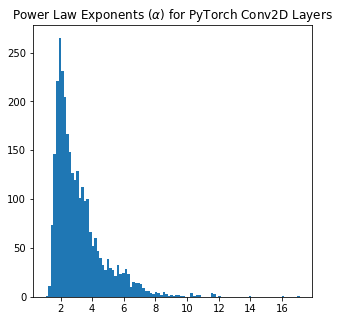

In [12]:
plt.hist(all_alphas,bins=100);
plt.title(r"Power Law Exponents ($\alpha$) for PyTorch Conv2D Layers")
plt.show()

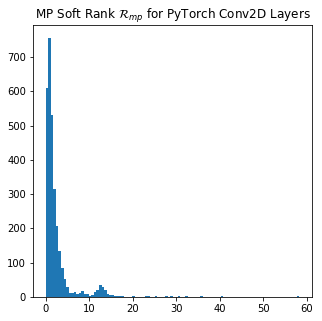

In [14]:
plt.hist(all_ranks,bins=100);
plt.title(r"MP Soft Rank $\mathcal{R}_{mp}$ for PyTorch Conv2D Layers")
plt.show()

In [16]:
aa = np.array(all_alphas)

In [19]:
len(aa), len(aa[aa<5])

(2971, 2595)

In [25]:
100.0*len(aa[aa<5])/len(aa), 100.0*len(aa[aa<4])/len(aa),  100.0*len(aa[aa<1.5])/len(aa)

(87.34432850891956, 78.55940760686637, 1.682935038707506)